In [1]:
# lib version used for project. Uncomment and install if needed
# !pip install pandas==1.5.0
# !pip install numpy==1.23.3

In [2]:
# Core libs
import pandas as pd
import numpy as np

# Handling datetime objects
from datetime import datetime, timedelta

# Fancy print
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import itertools

# In pandas sometimes false-positive copy-warning occur. These might be noisy. 
# lets's turn them off for school project
# I will also turn off future warnings, not needed fo school project
import warnings
from pandas.errors import SettingWithCopyWarning

# Clustering
from sklearn.cluster import KMeans

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# 1. Reading and printing data
df = pd.read_csv('solar_221298.csv')
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000000  0.0         -3.9        NaN        0.0        0.0
1  1612227600000  0.0         -3.5        NaN        0.0        0.0
2  1612231200000  0.0         -3.0        0.0        0.0        0.0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    17016 non-null  int64  
 1   raw          17016 non-null  float64
 2   temperature  17016 non-null  float64
 3   modified1    15825 non-null  float64
 4   modified2    15641 non-null  float64
 5   modified3    15879 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 797.8 KB


In [5]:
df.describe()

timestamp            raw   temperature      modified1  \
count  1.701600e+04   17016.000000  17016.000000   15825.000000   
mean   1.643547e+12   36912.094888      6.609191   37039.325457   
std    1.797037e+10   66907.410347      9.292033   66991.067211   
min    1.612224e+12       0.000000    -24.500000       0.000000   
25%    1.628056e+12       0.000000     -0.200000       0.000000   
50%    1.643715e+12       0.000000      6.400000       0.000000   
75%    1.659028e+12   38258.015000     13.400000   38994.080000   
max    1.675292e+12  301630.010000     30.100000  301630.010000   

           modified2      modified3  
count   15641.000000   15879.000000  
mean    25506.277558   33958.829309  
std     50828.415005   65118.934709  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%     22090.490000   30661.975000  
max    266069.210000  301630.010000

In [6]:
df = df.sort_values(by=['timestamp'])  # lets sort the data first
df = df.reset_index(drop=True)  # and reset index (it is usefull in case if rows were shifted)
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000000  0.0         -3.9        NaN        0.0        0.0
1  1612227600000  0.0         -3.5        NaN        0.0        0.0
2  1612231200000  0.0         -3.0        0.0        0.0        0.0

In [7]:
# let's now work with data simplification and type casting
df['timestamp'] = (df['timestamp'] / 1000).astype('uint32')  # drop miliseconds
df, df.info()  # now we occupy just 731/798*100 = 91.6% of initial memory, quite nice improvement with just a one-liner

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17016 entries, 0 to 17015
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    17016 non-null  uint32 
 1   raw          17016 non-null  float64
 2   temperature  17016 non-null  float64
 3   modified1    15825 non-null  float64
 4   modified2    15641 non-null  float64
 5   modified3    15879 non-null  float64
dtypes: float64(5), uint32(1)
memory usage: 731.3 KB


(        timestamp  raw  temperature  modified1  modified2  modified3
 0      1612224000  0.0         -3.9        NaN        0.0        0.0
 1      1612227600  0.0         -3.5        NaN        0.0        0.0
 2      1612231200  0.0         -3.0        0.0        0.0        0.0
 3      1612234800  0.0         -2.6        0.0        0.0        0.0
 4      1612238400  0.0         -2.4        0.0        0.0        0.0
 ...           ...  ...          ...        ...        ...        ...
 17011  1675278000  0.0          0.0        NaN        0.0        0.0
 17012  1675281600  0.0          0.1        0.0        0.0        0.0
 17013  1675285200  0.0          0.1        0.0        0.0        0.0
 17014  1675288800  0.0          0.2        0.0        0.0        0.0
 17015  1675292400  0.0          0.2        0.0        0.0        0.0
 
 [17016 rows x 6 columns],
 None)

In [8]:
# Check time step of provided data
(df[['timestamp']] - df[['timestamp']].shift(1))['timestamp'].value_counts()

3600.0      17004
90000.0        10
954000.0        1
Name: timestamp, dtype: int64

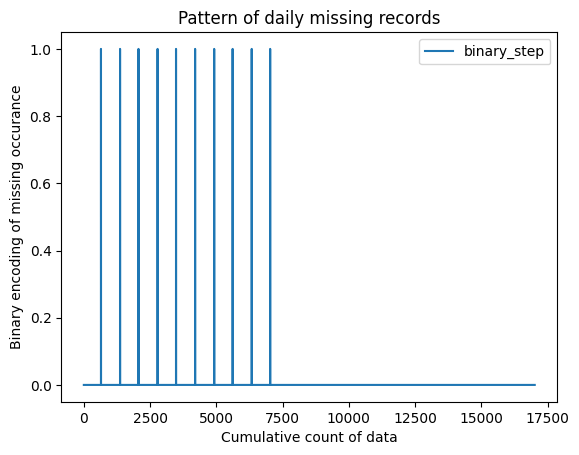

In [9]:
df['timestamp_shifted'] = (df['timestamp'] - df['timestamp'].shift(1))
df['cumcount'] = df.index - 1

df.loc[(df['timestamp_shifted'] >= 5000) & (df['timestamp_shifted'] < 100000), 'binary_step'] = 1

df['binary_step'] = df['binary_step'].fillna(0)
df[1:].plot(x='cumcount',y='binary_step')

plt.title("Pattern of daily missing records")
plt.xlabel("Cumulative count of data")
plt.ylabel("Binary encoding of missing occurance")
plt.show()

In [10]:
# Droping previosly enginered features at the moment
df = df.drop(columns=['timestamp_shifted','cumcount','binary_step'])
df.head(3)

timestamp  raw  temperature  modified1  modified2  modified3
0  1612224000  0.0         -3.9        NaN        0.0        0.0
1  1612227600  0.0         -3.5        NaN        0.0        0.0
2  1612231200  0.0         -3.0        0.0        0.0        0.0

In [11]:
# Converting features further.
# Simplifing data for columns ['raw', 'modified1', 'modified2', 'modified3']

feature_list = ['raw', 'modified1', 'modified2', 'modified3']

for feature in feature_list:
    df[feature] = df[feature] / 1000  # going to kWh scale

df.describe()

timestamp           raw   temperature     modified1     modified2  \
count  1.701600e+04  17016.000000  17016.000000  15825.000000  15641.000000   
mean   1.643547e+09     36.912095      6.609191     37.039325     25.506278   
std    1.797037e+07     66.907410      9.292033     66.991067     50.828415   
min    1.612224e+09      0.000000    -24.500000      0.000000      0.000000   
25%    1.628056e+09      0.000000     -0.200000      0.000000      0.000000   
50%    1.643715e+09      0.000000      6.400000      0.000000      0.000000   
75%    1.659028e+09     38.258015     13.400000     38.994080     22.090490   
max    1.675292e+09    301.630010     30.100000    301.630010    266.069210   

          modified3  
count  15879.000000  
mean      33.958829  
std       65.118935  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       30.661975  
max      301.630010

In [12]:
# lets add datetime format series to existing dataframe to make it easier to undrestand what is going on for humans
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.head(3)  # now take couple of instances and check if convertion was succesfull using epoch converters found in web 

timestamp  raw  temperature  modified1  modified2  modified3  \
0  1612224000  0.0         -3.9        NaN        0.0        0.0   
1  1612227600  0.0         -3.5        NaN        0.0        0.0   
2  1612231200  0.0         -3.0        0.0        0.0        0.0   

             datetime  
0 2021-02-02 00:00:00  
1 2021-02-02 01:00:00  
2 2021-02-02 02:00:00

In [13]:
# Now lets check if there are duplicates in datetime and/or timestapms (maybe leap year inside the data)
df['datetime'].value_counts().nunique(), df['timestamp'].value_counts().nunique()  # datetime and timestamp are unique values, no leap year present in the data

(1, 1)

In [14]:
# Lets rearange columns to make it bit more convinient
df = df[['timestamp','datetime','raw','modified1','modified2','modified3','temperature']]
df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  
0         -3.9  
1         -3.5  
2         -3.0

In [15]:
# Lets start with investigating NaN's
nrows = df.shape[0]

# Printing column-based NaN data
pd.DataFrame({'column_name':df.columns,
              'missing_data_count':df.isnull().sum().to_list(),
              'missing_data_%':round(df.isnull().sum() / nrows * 100, 2).to_list()})

column_name  missing_data_count  missing_data_%
0    timestamp                   0            0.00
1     datetime                   0            0.00
2          raw                   0            0.00
3    modified1                1191            7.00
4    modified2                1375            8.08
5    modified3                1137            6.68
6  temperature                   0            0.00

In [16]:
# Lets declare a function which will pretty-print missing values for us
# White strips will signalise missing values and black present data

def fancy_print_missingno(df:pd.DataFrame,col:str) -> None:
    
    '''
    Method to plot missing values of pandas df series
    '''
    
    data = df[col].apply(lambda x: 1 if pd.notna(x) else 0).to_numpy()  # this will convert notnan's to 1 and nan's to 0, binary vector basically
    data = np.array([data])  # need 2D for imshow() function

    plt.figure(figsize=(40, 1))  # to make a print in a form of flat bar
    
    cmap = mcolors.ListedColormap(['white', 'black'])
    
    plt.imshow(data, cmap=cmap, aspect='auto', interpolation='nearest')
    
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

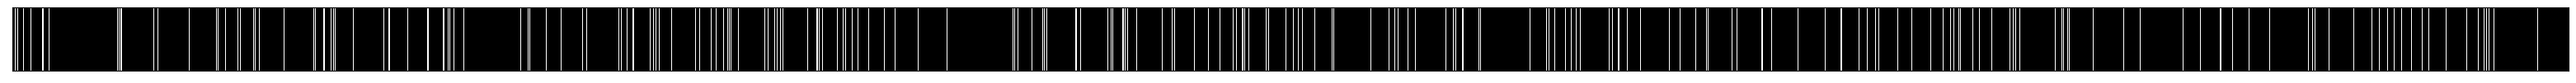

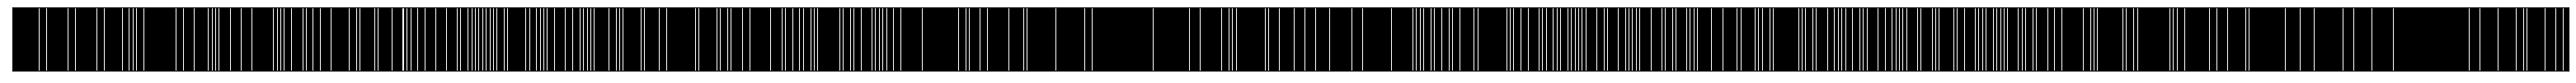

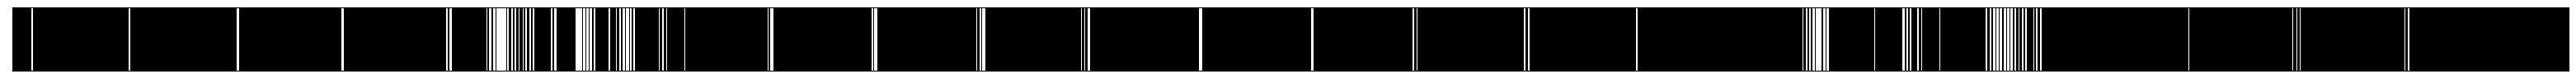

(None, None, None)

In [17]:
fancy_print_missingno(df=df,col='modified1'), fancy_print_missingno(df=df,col='modified2'), fancy_print_missingno(df=df,col='modified3')

In [18]:
df['day_of_week'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

# And because I want to represent day of week, month and hour as nominal features for correlation nalysis, I will one-hot-encode them
cols_to_encode = ['day_of_week','month','hour']
df_cols_to_encode = df[cols_to_encode]

df = pd.get_dummies(df, columns=cols_to_encode, drop_first=False)
df = pd.concat([df,df_cols_to_encode],axis=1)

df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  day_of_week_0  day_of_week_1  day_of_week_2  ...  hour_17  \
0         -3.9              0              1              0  ...        0   
1         -3.5              0              1              0  ...        0   
2         -3.0              0              1              0  ...        0   

   hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  day_of_week  month  \
0        0        0        0        0        0        0            1      2   
1        0        0        0        0        0        0            1      2   
2        0        0        0        0        0        0            1      2   

   hour  
0     0  
1     1  
2     2  

[3 rows x 53 columns]

In [19]:
# And I will represent modified1, modified2 and modified3 as binary vectors to catch correlations between presence 0/1 rather magnitude value of these columns
for column in ['modified1', 'modified2', 'modified3']:
    df[column + '_binary'] = df[column].apply(lambda x: 1 if pd.notna(x) else 0)
df.head(3)

timestamp            datetime  raw  modified1  modified2  modified3  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN        0.0        0.0   
1  1612227600 2021-02-02 01:00:00  0.0        NaN        0.0        0.0   
2  1612231200 2021-02-02 02:00:00  0.0        0.0        0.0        0.0   

   temperature  day_of_week_0  day_of_week_1  day_of_week_2  ...  hour_20  \
0         -3.9              0              1              0  ...        0   
1         -3.5              0              1              0  ...        0   
2         -3.0              0              1              0  ...        0   

   hour_21  hour_22  hour_23  day_of_week  month  hour  modified1_binary  \
0        0        0        0            1      2     0                 0   
1        0        0        0            1      2     1                 0   
2        0        0        0            1      2     2                 1   

   modified2_binary  modified3_binary  
0                 1                 1  
1                 1                 1  
2                 1                 1  

[3 rows x 56 columns]

In [20]:
# Finally, lets calculate correlations
df_corr = pd.DataFrame()

for column in ['modified1_binary', 'modified2_binary', 'modified3_binary']:
    df_corr = pd.concat([df_corr,df.corr(numeric_only=True)[column].reset_index()],axis=1,)

df_corr = df_corr.loc[:, ~df_corr.columns.duplicated()]
df_corr = df_corr.loc[~df_corr['index'].isin(['timestamp','raw','modified1','modified2','modified3',
                                             'modified1_binary','modified2_binary','modified3_binary']), :]
df_corr.head(5)

index  modified1_binary  modified2_binary  modified3_binary
5    temperature          0.009238         -0.116066         -0.501724
6  day_of_week_0         -0.005967         -0.009952         -0.001781
7  day_of_week_1         -0.014871          0.005415         -0.014368
8  day_of_week_2         -0.004176          0.007943         -0.000020
9  day_of_week_3          0.025798         -0.001279          0.002276

In [21]:
# And analyse correlation for each feature. 
# Feature modified1
modified1_corrs = df_corr[['index','modified1_binary']].sort_values(by=['modified1_binary'])
modified1_corrs['modified1_binary_abs'] = modified1_corrs['modified1_binary'].abs()
modified1_corrs.sort_values(by='modified1_binary_abs',ascending=False).head(10)

index  modified1_binary  modified1_binary_abs
9   day_of_week_3          0.025798              0.025798
31         hour_6          0.016858              0.016858
32         hour_7          0.016858              0.016858
48        hour_23          0.015706              0.015706
7   day_of_week_1         -0.014871              0.014871
41        hour_16         -0.013112              0.013112
21        month_9         -0.012417              0.012417
30         hour_5         -0.011959              0.011959
37        hour_12         -0.011959              0.011959
43        hour_18         -0.010807              0.010807

In [22]:
# Feature modified2
modified2_corrs = df_corr[['index','modified2_binary']].sort_values(by=['modified2_binary'])
modified2_corrs['modified2_binary_abs'] = modified2_corrs['modified2_binary'].abs()
modified2_corrs.sort_values(by='modified2_binary_abs',ascending=False).head(10)

index  modified2_binary  modified2_binary_abs
35      hour_10         -0.270541              0.270541
36      hour_11         -0.238167              0.238167
34       hour_9         -0.232772              0.232772
37      hour_12         -0.144285              0.144285
33       hour_8         -0.135652              0.135652
5   temperature         -0.116066              0.116066
51         hour          0.066305              0.066305
28       hour_3          0.061824              0.061824
29       hour_4          0.061824              0.061824
27       hour_2          0.061824              0.061824

In [23]:
df.groupby('hour')['modified2_binary'].sum()

hour
0     709
1     709
2     709
3     709
4     709
5     709
6     705
7     627
8     526
9     436
10    401
11    431
12    518
13    660
14    702
15    709
16    709
17    709
18    709
19    709
20    709
21    709
22    709
23    709
Name: modified2_binary, dtype: int64

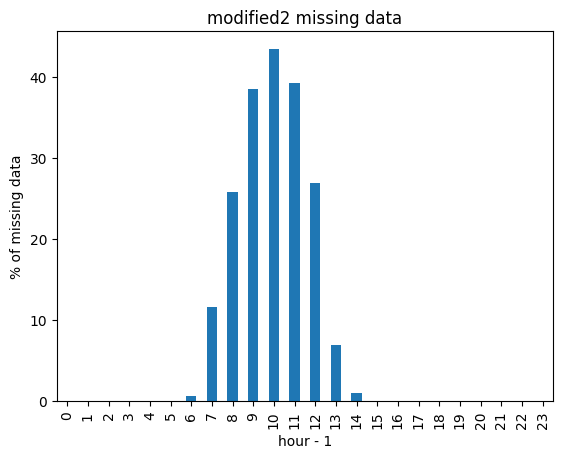

In [24]:
(100 - df.groupby('hour')['modified2_binary'].sum()/709*100).plot.bar(xlabel='hour - 1', 
                                                                      ylabel='% of missing data', 
                                                                      title='modified2 missing data')
plt.show()

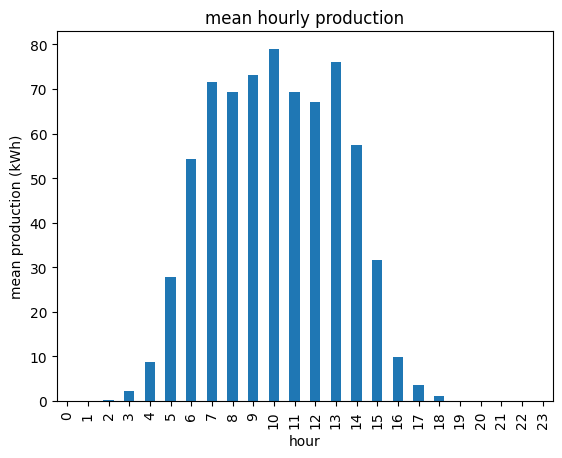

In [25]:
df.groupby('hour')['modified2'].mean().plot.bar(xlabel='hour', 
                                                ylabel='mean production (kWh)', 
                                                title='mean hourly production')
plt.show()

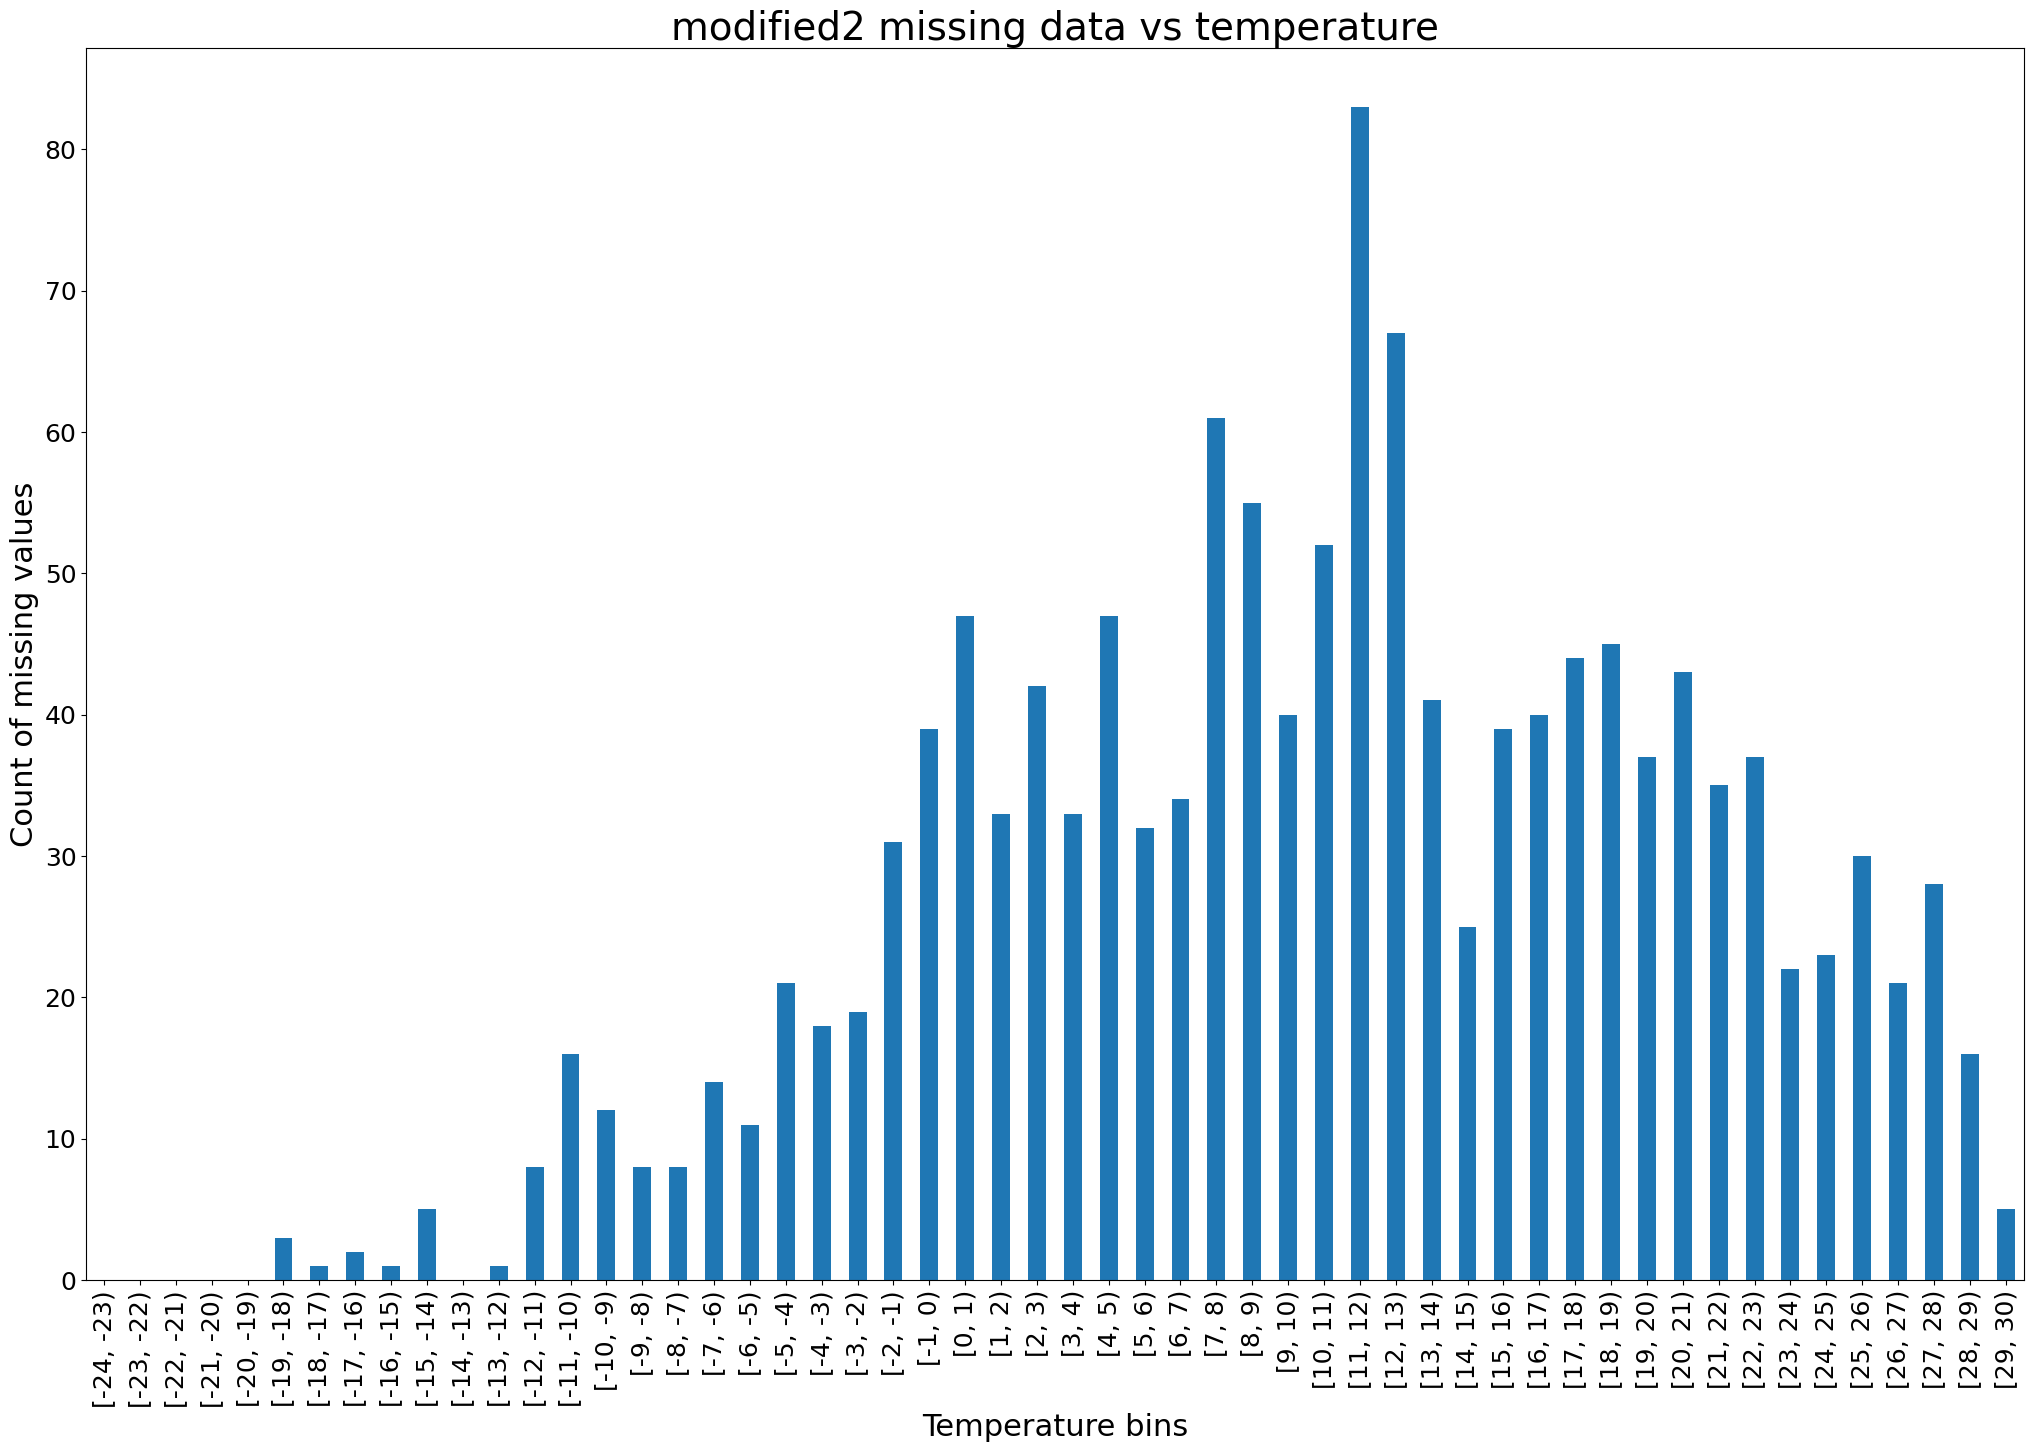

In [26]:
# Lets also check correlations between missing values of modified2 and temperature
degree_step = 1
bins = range(int(df['temperature'].min()), int(df['temperature'].max()) + degree_step, degree_step)
df['temp_bin'] = pd.cut(df['temperature'], bins=bins, right=False)
df.groupby('temp_bin')['modified2'].apply(lambda x: x.isna().sum()).plot.bar(figsize=(25,16))

plt.xlabel("Temperature bins", fontsize=22)
plt.ylabel("Count of missing values", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('modified2 missing data vs temperature',fontsize=28)
plt.show()

In [27]:
# Feature modified3
modified3_corrs = df_corr[['index','modified3_binary']].sort_values(by=['modified3_binary'])
modified3_corrs['modified3_binary_abs'] = modified3_corrs['modified3_binary'].abs()
modified3_corrs.sort_values(by='modified3_binary_abs',ascending=False).head(10)

index  modified3_binary  modified3_binary_abs
5   temperature         -0.501724              0.501724
18      month_6         -0.197153              0.197153
19      month_7         -0.145342              0.145342
20      month_8         -0.109253              0.109253
21      month_9          0.059318              0.059318
15      month_3          0.058601              0.058601
38      hour_13         -0.057268              0.057268
37      hour_12         -0.057268              0.057268
13      month_1          0.057191              0.057191
27       hour_2          0.052263              0.052263

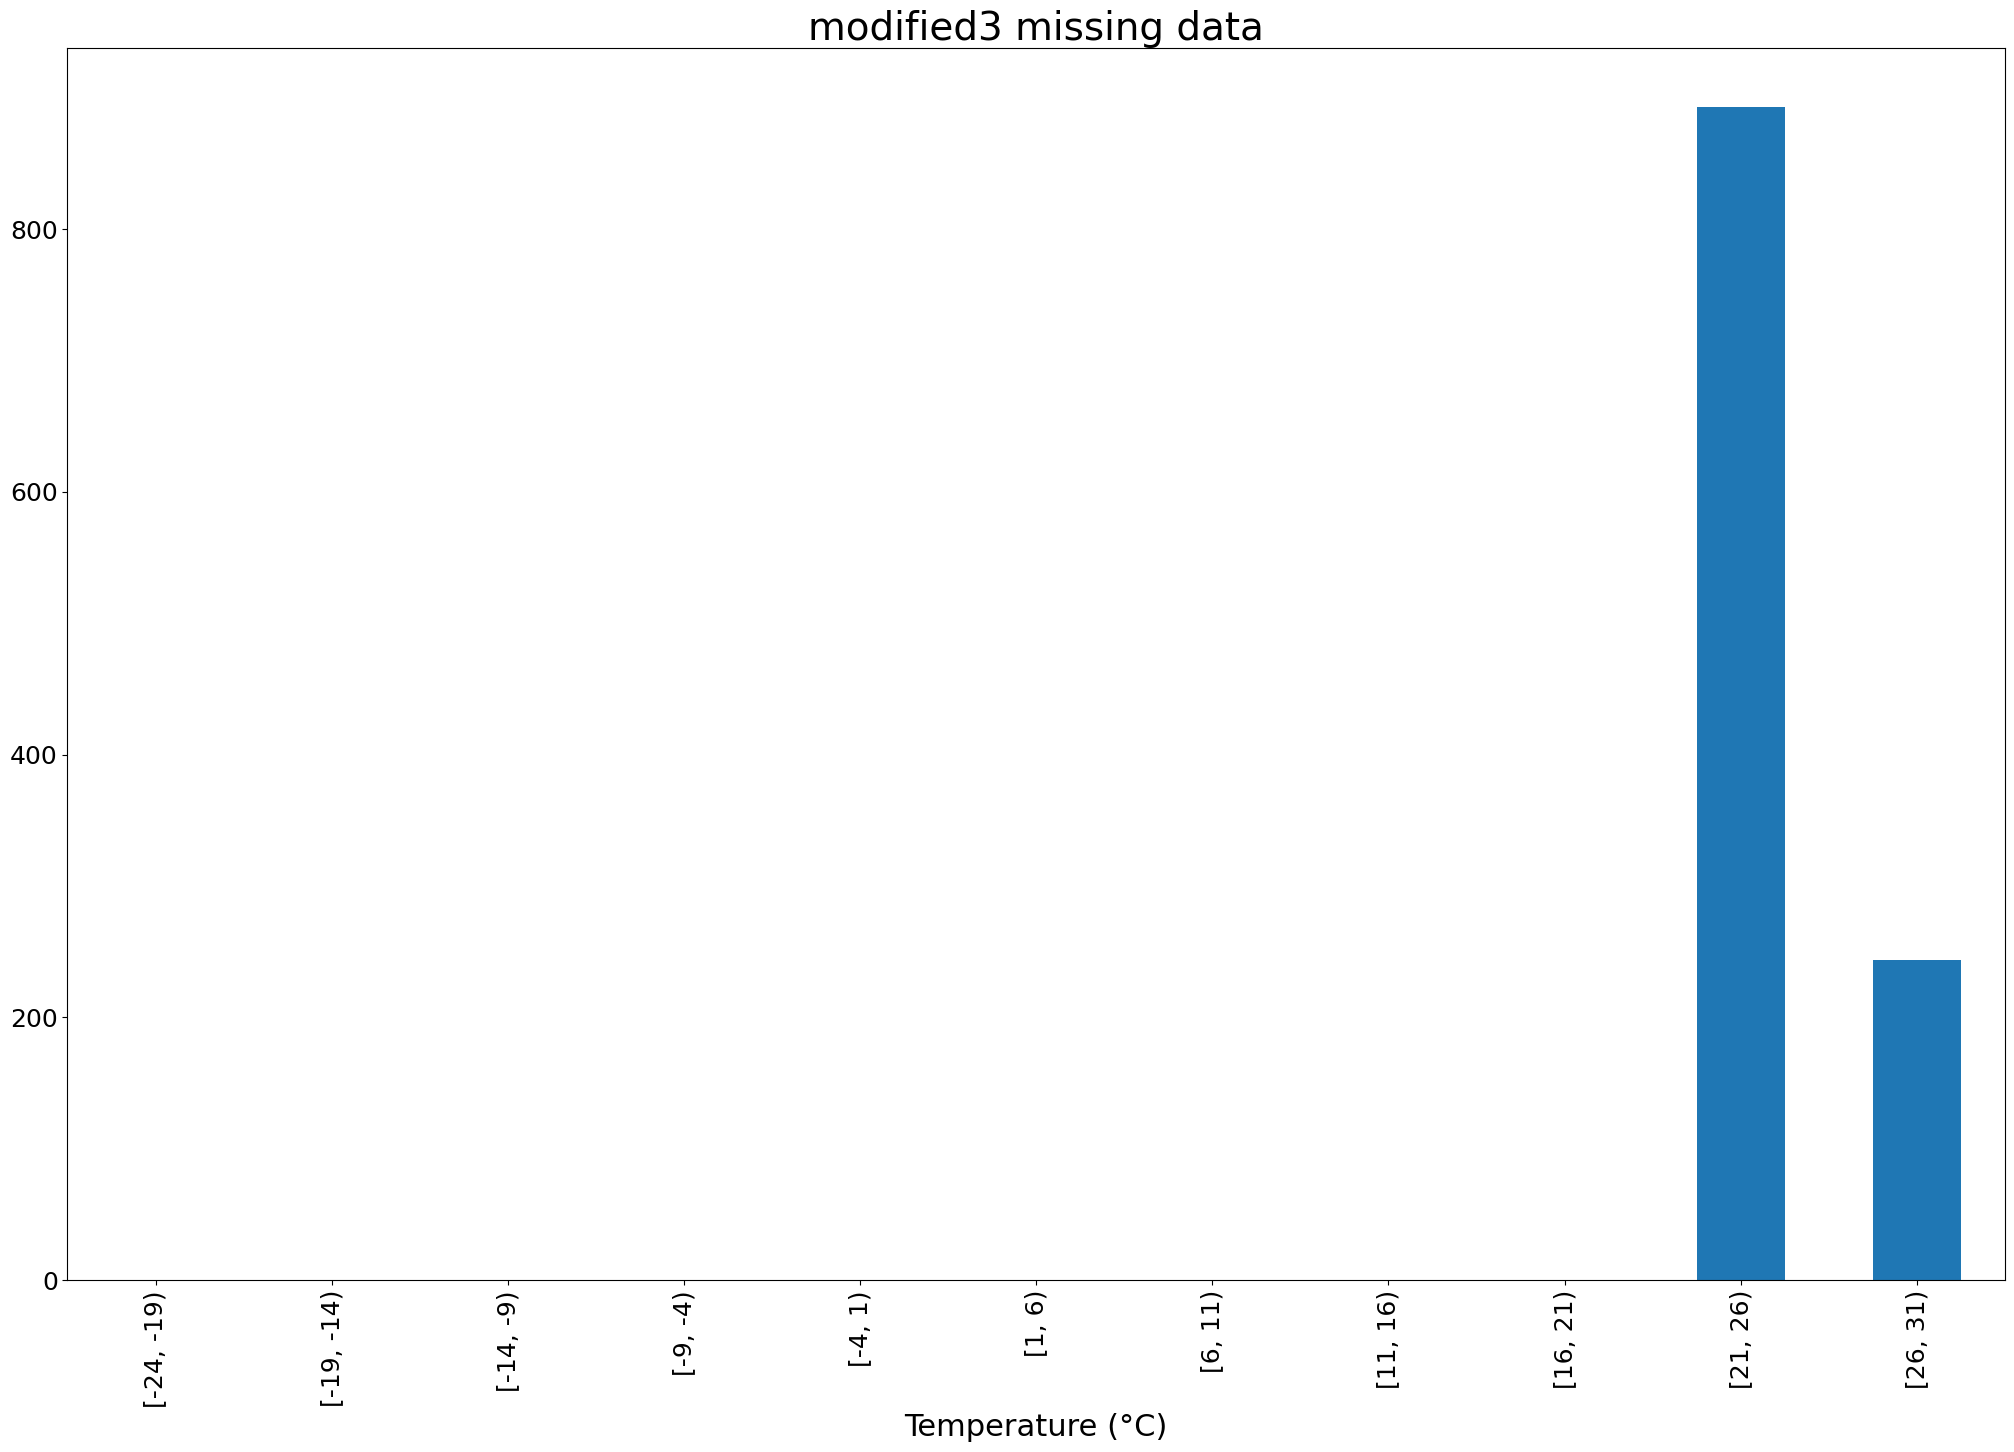

In [28]:
degree_step = 5
bins = range(int(df['temperature'].min()), int(df['temperature'].max()) + degree_step, degree_step)
df['temp_bin'] = pd.cut(df['temperature'], bins=bins, right=False)
df.groupby('temp_bin')['modified3'].apply(lambda x: x.isna().sum()).plot.bar(figsize=(25,16))
plt.xlabel("Temperature (°C)", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('modified3 missing data',fontsize=28)
plt.show()

In [29]:
df[df['modified3'].notna()]['temperature'].max(), df['temperature'].max()

(21.0, 30.1)

In [30]:
df = df[['timestamp','datetime','raw','modified1','temperature']]
df

timestamp            datetime  raw  modified1  temperature
0      1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9
1      1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5
2      1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0
3      1612234800 2021-02-02 03:00:00  0.0        0.0         -2.6
4      1612238400 2021-02-02 04:00:00  0.0        0.0         -2.4
...           ...                 ...  ...        ...          ...
17011  1675278000 2023-02-01 19:00:00  0.0        NaN          0.0
17012  1675281600 2023-02-01 20:00:00  0.0        0.0          0.1
17013  1675285200 2023-02-01 21:00:00  0.0        0.0          0.1
17014  1675288800 2023-02-01 22:00:00  0.0        0.0          0.2
17015  1675292400 2023-02-01 23:00:00  0.0        0.0          0.2

[17016 rows x 5 columns]

In [31]:
# a. Handling missing data on deletion
df_clean_on_deletion = df[df['modified1'].notna()].reset_index(drop=True)
df_clean_on_deletion

timestamp            datetime  raw  modified1  temperature
0      1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0
1      1612234800 2021-02-02 03:00:00  0.0        0.0         -2.6
2      1612238400 2021-02-02 04:00:00  0.0        0.0         -2.4
3      1612242000 2021-02-02 05:00:00  0.0        0.0         -2.1
4      1612245600 2021-02-02 06:00:00  0.0        0.0         -2.0
...           ...                 ...  ...        ...          ...
15820  1675274400 2023-02-01 18:00:00  0.0        0.0         -0.3
15821  1675281600 2023-02-01 20:00:00  0.0        0.0          0.1
15822  1675285200 2023-02-01 21:00:00  0.0        0.0          0.1
15823  1675288800 2023-02-01 22:00:00  0.0        0.0          0.2
15824  1675292400 2023-02-01 23:00:00  0.0        0.0          0.2

[15825 rows x 5 columns]

In [32]:
# b. Handling missing data on univariante imputation
# First of all I will introduce additional columns: date, hour and step

In [33]:
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['step'] = df.groupby('date').cumcount() + 1
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  
0     0     1  
1     1     2  
2     2     3

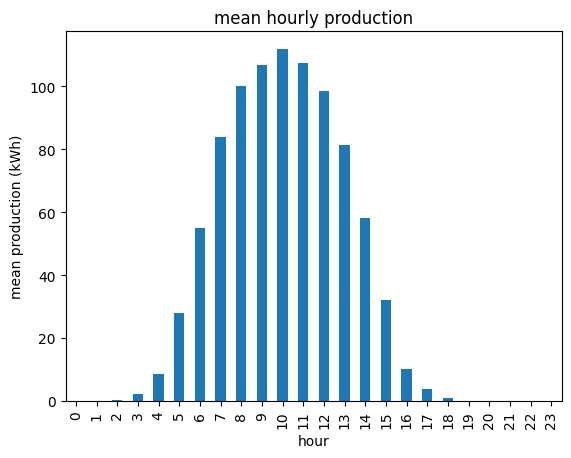

In [34]:
df.groupby('hour')['modified1'].mean().plot.bar(xlabel='hour', 
                                                ylabel='mean production (kWh)', 
                                                title='mean hourly production')
plt.show()

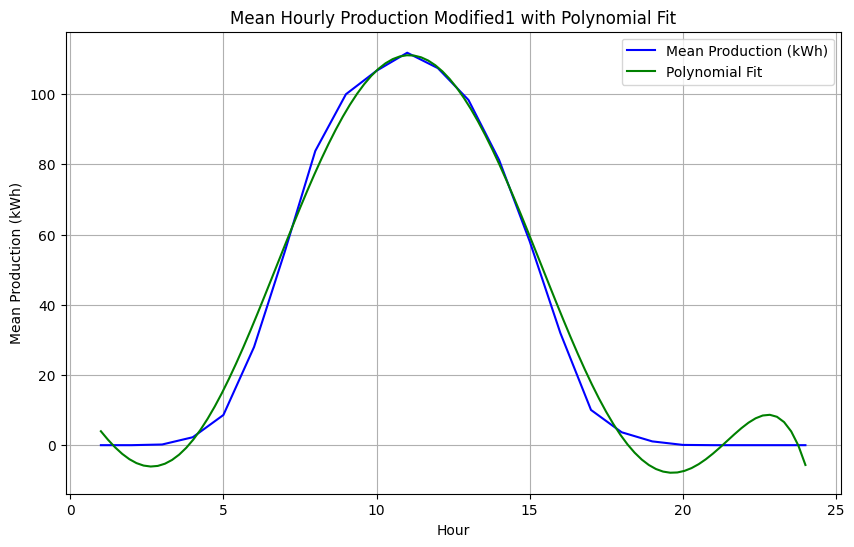

In [35]:
mean_values = df.groupby('step')['modified1'].mean()
poly_strength = 6

coefficients = np.polyfit(mean_values.index, mean_values.values, poly_strength)
polynomial = np.poly1d(coefficients)

x_values = np.linspace(mean_values.index.min(), mean_values.index.max(), 100)
y_values = polynomial(x_values)


plt.figure(figsize=(10, 6))
mean_values.plot(label='Mean Production (kWh)', color='blue')
plt.plot(x_values, y_values, label='Polynomial Fit', color='green')

# Adding labels and title
plt.xlabel('Hour')
plt.ylabel('Mean Production (kWh)')
plt.title('Mean Hourly Production Modified1 with Polynomial Fit')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [36]:
# Spaghetti-Code Warning
# Achtung! Spaghetti-Code used for inputations below...

In [37]:
# Declaring spaghetti columns
df['to_fill'] = df['modified1']
df['modified1_single_inputation'] = df['modified1']
df['modified1_multi_inputation'] = df['modified1']
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  to_fill  modified1_single_inputation  \
0     0     1      NaN                          NaN   
1     1     2      NaN                          NaN   
2     2     3      0.0                          0.0   

   modified1_multi_inputation  
0                         NaN  
1                         NaN  
2                         0.0

In [38]:
# This chunk is used to calculate single shot imputation

poly_strength = 6


def fit_polynomial(group):
        
    x = group[~group['modified1'].isna()]['step'].to_list()
    y = group[~group['modified1'].isna()]['modified1'].to_list()
        
    coefficients = np.polyfit(x, y, poly_strength)
    polynomial = np.poly1d(coefficients)

    missing_hours = group[group['to_fill'].isna()]['step']
        
    group.loc[group['to_fill'].isna(), 'modified1_single_inputation'] = polynomial(missing_hours.to_list())
    
    return group

df = df.groupby('date').apply(fit_polynomial)
df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  to_fill  modified1_single_inputation  \
0     0     1      NaN                          0.0   
1     1     2      NaN                          0.0   
2     2     3      0.0                          0.0   

   modified1_multi_inputation  
0                         NaN  
1                         NaN  
2                         0.0

In [39]:
# This chunk is for multivariate imputation
# For multivariate, I am using neighbours of days and calculation hourly mean values 

df['modified1_3day_mean'] = df.groupby('step')['to_fill'].rolling(window=3, min_periods=1,center=True).mean().reset_index(level=0, drop=True)

poly_strength = 6

def fit_polynomial(group):
    
    x = group[~group['modified1_3day_mean'].isna()]['step'].to_list()
    y = group[~group['modified1_3day_mean'].isna()]['modified1_3day_mean'].to_list()
    
    coefficients = np.polyfit(x, y, poly_strength)
    polynomial = np.poly1d(coefficients)

    missing_hours = group[group['to_fill'].isna()]['step']
    group.loc[group['to_fill'].isna(), 'modified1_multi_inputation'] = polynomial(missing_hours)

    return group

df = df.groupby('date').apply(fit_polynomial)
df = df.drop(columns=['modified1_3day_mean','to_fill'])  # droping what is not needed any more

df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  modified1_single_inputation  modified1_multi_inputation  
0     0     1                          0.0                         0.0  
1     1     2                          0.0                         0.0  
2     2     3                          0.0                         0.0

In [40]:
# Shaving zero's as we know that PV haven't been acting in consumer mode
df.loc[df['modified1_single_inputation'] < 0, 'modified1_single_inputation_shaved'] = 0
df.loc[df['modified1_multi_inputation'] < 0, 'modified1_multi_inputation_shaved'] = 0

df['modified1_single_inputation_shaved'] = df['modified1_single_inputation_shaved'].fillna(df['modified1_single_inputation'])
df['modified1_multi_inputation_shaved'] = df['modified1_multi_inputation_shaved'].fillna(df['modified1_multi_inputation'])

df.head(3)

timestamp            datetime  raw  modified1  temperature        date  \
0  1612224000 2021-02-02 00:00:00  0.0        NaN         -3.9  2021-02-02   
1  1612227600 2021-02-02 01:00:00  0.0        NaN         -3.5  2021-02-02   
2  1612231200 2021-02-02 02:00:00  0.0        0.0         -3.0  2021-02-02   

   hour  step  modified1_single_inputation  modified1_multi_inputation  \
0     0     1                          0.0                         0.0   
1     1     2                          0.0                         0.0   
2     2     3                          0.0                         0.0   

   modified1_single_inputation_shaved  modified1_multi_inputation_shaved  
0                                 0.0                                0.0  
1                                 0.0                                0.0  
2                                 0.0                                0.0

In [41]:
def nrows(df):
    
    return df.shape[0]

In [42]:
def delta(df,actual_col,predicted_col):
    
    return df[actual_col] - df[predicted_col]

In [43]:
def mae_errors(df,actual_col,predicted_col):
    
    return delta(df,actual_col,predicted_col).abs()

In [44]:
def mape_errors(df,actual_col,predicted_col):
    
    df_discarded = df[df[actual_col] != 0]  # discard predictions where actual data is 0, bacause MAPE will be inf in that case 
    
    return (delta(df_discarded,actual_col,predicted_col)/(df_discarded[actual_col])).abs()

In [45]:
def mse_errors(df,actual_col,predicted_col):
    
    return delta(df,actual_col,predicted_col) ** 2

In [46]:
def mae(df,actual_col,predicted_col):

    return mae_errors(df,actual_col,predicted_col).sum() / nrows(df)

In [47]:
def mape(df,actual_col,predicted_col):
    
    return mape_errors(df,actual_col,predicted_col).sum() / nrows(mape_errors(df,actual_col,predicted_col))

In [48]:
def mse(df,actual_col,predicted_col):
    
    return mse_errors(df,actual_col,predicted_col).sum() / nrows(df)

In [49]:
def se(errors):
    
    return errors.std() / np.sqrt(errors.shape[0])

In [50]:
# MAE
{
    'modified1_single_inputation':mae(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mae(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mae(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mae(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 1.195,
 'modified1_multi_inputation': 1.172,
 'modified1_single_inputation_shaved': 0.811,
 'modified1_multi_inputation_shaved': 1.044}

In [51]:
# MAE Standard Error
{
    'se_modified1_single_inputation':se(mae_errors(df,'raw','modified1_single_inputation')).round(3),
    'se_modified1_multi_inputation':se(mae_errors(df,'raw','modified1_multi_inputation')).round(3),
    'se_modified1_single_inputation_shaved':se(mae_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'se_modified1_multi_inputation_shaved':se(mae_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'se_modified1_single_inputation': 0.067,
 'se_modified1_multi_inputation': 0.06,
 'se_modified1_single_inputation_shaved': 0.046,
 'se_modified1_multi_inputation_shaved': 0.059}

In [52]:
# quasi MAPE (zeros discarded)
{
    'modified1_single_inputation':mape(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mape(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mape(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mape(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 5.925,
 'modified1_multi_inputation': 3.265,
 'modified1_single_inputation_shaved': 2.458,
 'modified1_multi_inputation_shaved': 1.673}

In [53]:
# quasi MAPE (zeros discarded) Standard Error
{
    'modified1_single_inputation':se(mape_errors(df,'raw','modified1_single_inputation')).round(3),
    'modified1_multi_inputation':se(mape_errors(df,'raw','modified1_multi_inputation')).round(3),
    'modified1_single_inputation_shaved':se(mape_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'modified1_multi_inputation_shaved':se(mape_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'modified1_single_inputation': 3.757,
 'modified1_multi_inputation': 1.906,
 'modified1_single_inputation_shaved': 1.642,
 'modified1_multi_inputation_shaved': 1.151}

In [54]:
# MSE
{
    'modified1_single_inputation':mse(df,'raw','modified1_single_inputation').round(3),
    'modified1_multi_inputation':mse(df,'raw','modified1_multi_inputation').round(3),
    'modified1_single_inputation_shaved':mse(df,'raw','modified1_single_inputation_shaved').round(3),
    'modified1_multi_inputation_shaved':mse(df,'raw','modified1_multi_inputation_shaved').round(3),
}

{'modified1_single_inputation': 78.312,
 'modified1_multi_inputation': 62.372,
 'modified1_single_inputation_shaved': 35.941,
 'modified1_multi_inputation_shaved': 60.612}

In [55]:
# MSE Standard Error
{
    'se_modified1_single_inputation':se(mse_errors(df,'raw','modified1_single_inputation')).round(3),
    'se_modified1_multi_inputation':se(mse_errors(df,'raw','modified1_multi_inputation')).round(3),
    'se_modified1_single_inputation_shaved':se(mse_errors(df,'raw','modified1_single_inputation_shaved')).round(3),
    'se_modified1_multi_inputation_shaved':se(mse_errors(df,'raw','modified1_multi_inputation_shaved')).round(3),
}

{'se_modified1_single_inputation': 16.504,
 'se_modified1_multi_inputation': 5.651,
 'se_modified1_single_inputation_shaved': 3.997,
 'se_modified1_multi_inputation_shaved': 5.646}

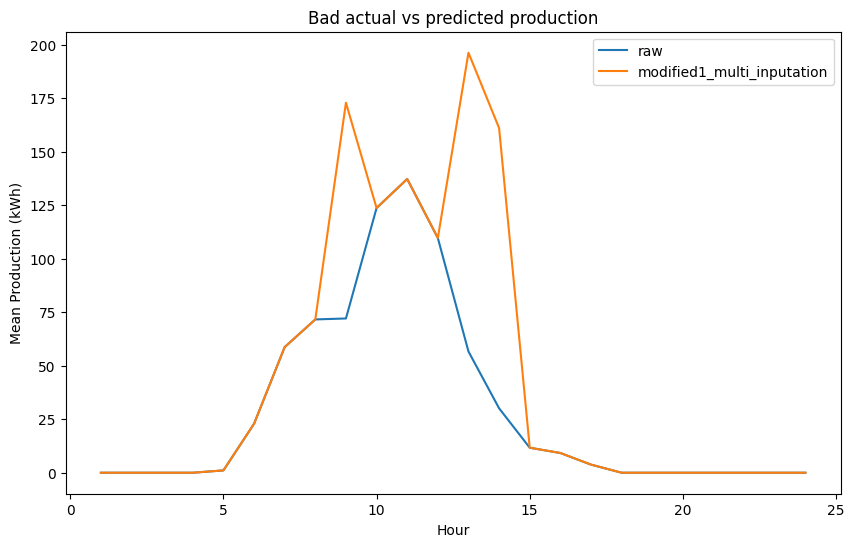

In [56]:
# lets check bad fit with large MSE errors
row_index = mse_errors(df,'raw','modified1_multi_inputation').sort_values().tail(5).index[0]
anomaly_date = anomaly_date = df[df.index == row_index]['date'].to_frame().reset_index(drop=True).loc[0,'date']

df[df['date'] == anomaly_date].plot('step',['raw','modified1_multi_inputation'],figsize=(10,6))

plt.xlabel('Hour')
plt.ylabel('Mean Production (kWh)')
plt.title('Bad actual vs predicted production')
plt.legend(loc='upper right')
plt.show()

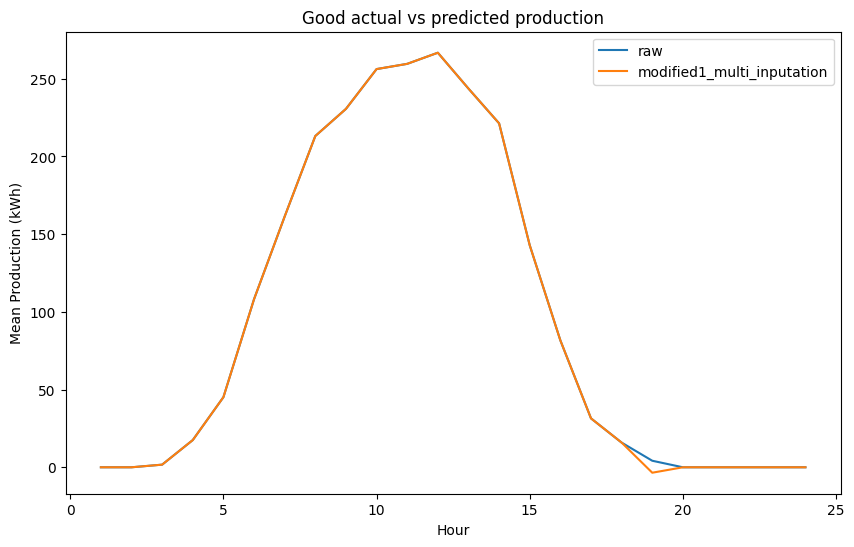

In [57]:
# lets check good fit with small MSE errors
row_index = mse_errors(df,'raw','modified1_multi_inputation').sort_values().head(50).index[49]
anomaly_date = anomaly_date = df[df.index == row_index]['date'].to_frame().reset_index(drop=True).loc[0,'date']

df[df['date'] == anomaly_date].plot('step',['raw','modified1_multi_inputation'],figsize=(10,6))

plt.xlabel('Hour')
plt.ylabel('Mean Production (kWh)')
plt.title('Good actual vs predicted production')
plt.legend(loc='upper right')
plt.show()

In [58]:
df = df[['timestamp','datetime','date','step','raw','temperature']]
df.head(3)

timestamp            datetime        date  step  raw  temperature
0  1612224000 2021-02-02 00:00:00  2021-02-02     1  0.0         -3.9
1  1612227600 2021-02-02 01:00:00  2021-02-02     2  0.0         -3.5
2  1612231200 2021-02-02 02:00:00  2021-02-02     3  0.0         -3.0

In [59]:
# I shall introduce additional hour column to perform analysis
df['hour'] = df['datetime'].dt.hour
df.head(3)

timestamp            datetime        date  step  raw  temperature  hour
0  1612224000 2021-02-02 00:00:00  2021-02-02     1  0.0         -3.9     0
1  1612227600 2021-02-02 01:00:00  2021-02-02     2  0.0         -3.5     1
2  1612231200 2021-02-02 02:00:00  2021-02-02     3  0.0         -3.0     2

In [60]:
df['raw'].describe(), df['raw'].quantile(0.9)

(count    17016.000000
 mean        36.912095
 std         66.907410
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%         38.258015
 max        301.630010
 Name: raw, dtype: float64,
 154.98941)

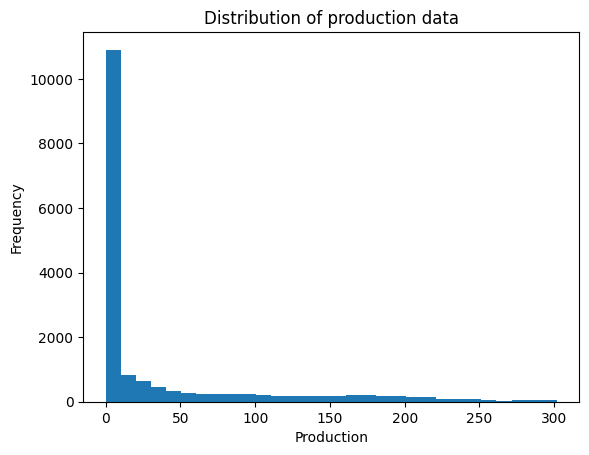

In [61]:
df['raw'].plot.hist(bins=30)

plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title('Distribution of production data')
plt.show()

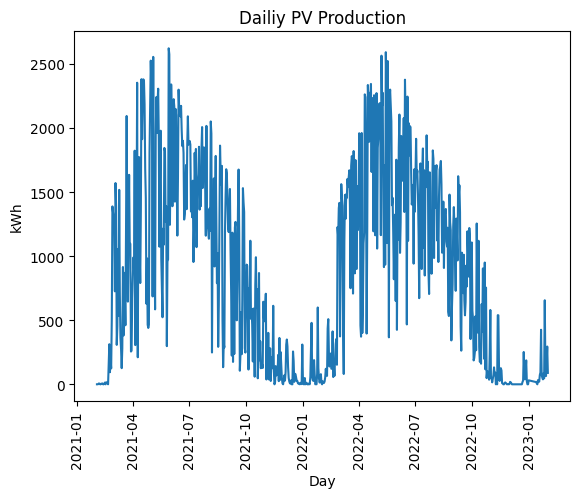

In [62]:
# Daily production of PV
df.groupby('date')['raw'].sum().plot()

plt.title("Dailiy PV Production")
plt.xlabel("Day")
plt.ylabel("kWh")
plt.xticks(rotation=90)
plt.show()

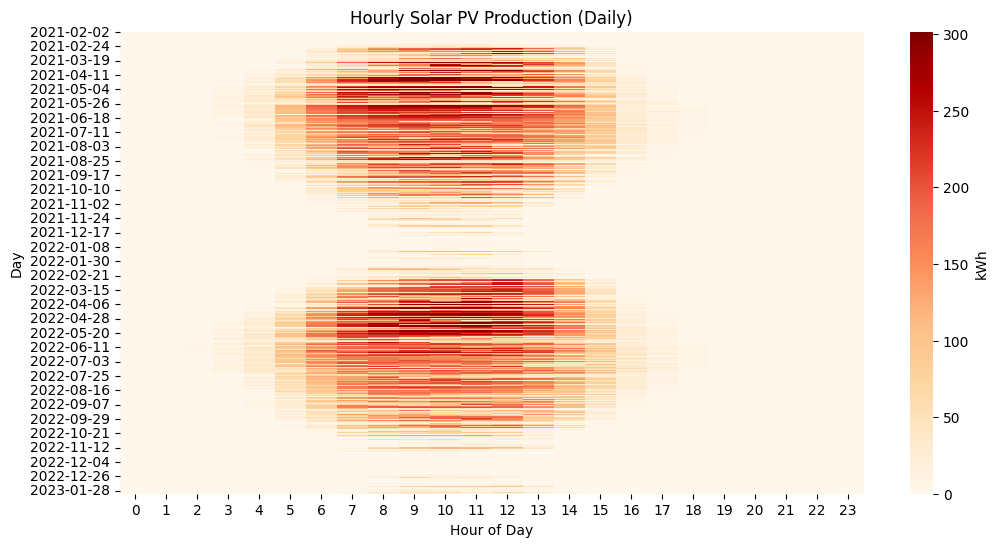

In [63]:
# Heat-map daily-hourly
hourly_avg = df.groupby('hour')['raw'].mean()
hourly_avg_df = df.pivot_table(values='raw', index=df['date'], columns=df['hour'])

plt.figure(figsize=(12, 6))
sns.heatmap(hourly_avg_df, cmap="OrRd", cbar_kws={'label': 'kWh'})
plt.title("Hourly Solar PV Production (Daily)")
plt.xlabel("Hour of Day")
plt.ylabel("Day")
plt.show()

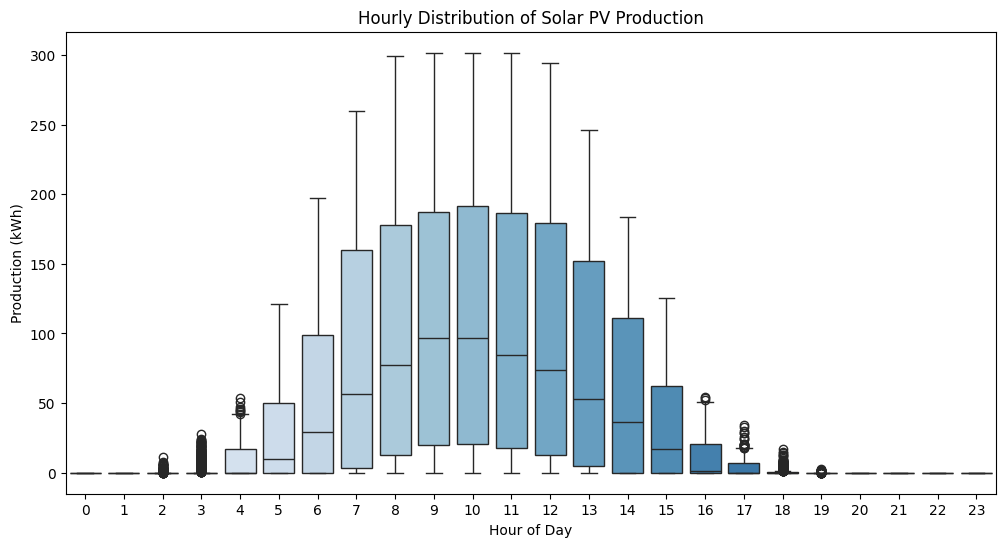

In [64]:
# Box plot hourly
df['hour'] = df['datetime'].dt.hour

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='raw', palette="Blues")
plt.title("Hourly Distribution of Solar PV Production")
plt.xlabel("Hour of Day")
plt.ylabel("Production (kWh)")
plt.show()


In [65]:
df['month'] = df['datetime'].dt.month

df_month_hour_production = df.groupby(['month','hour'])['raw'].sum().reset_index()
df_month_hour_production.loc[df_month_hour_production['raw'] == 0, 'sunny'] = 0
df_month_hour_production['sunny'] = df_month_hour_production['sunny'].fillna(1)
df_month_hour_production = df_month_hour_production.rename(columns={'raw':'sunny_production'})
df_month_hour_production = df_month_hour_production[['month','hour','sunny']]
df_month_hour_production.head(3)

month  hour  sunny
0      1     0    0.0
1      1     1    0.0
2      1     2    0.0

In [66]:
df = df.merge(df_month_hour_production,on=['month','hour'],how='inner')
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   sunny  
0    0.0  
1    0.0  
2    0.0

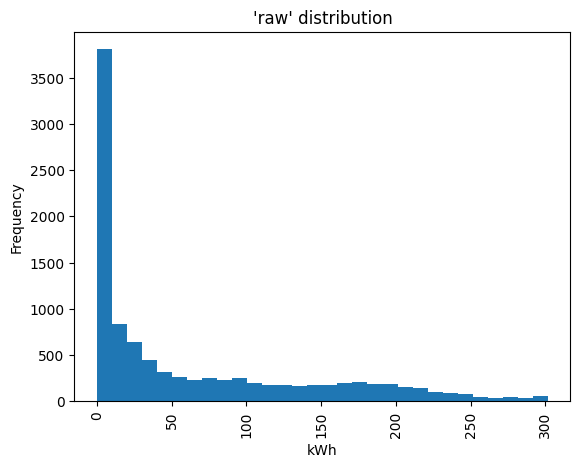

In [67]:
df_notnull = df[df['sunny'] > 0].reset_index()
df_notnull['raw'].plot.hist(bins=30)

plt.title("'raw' distribution")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [68]:
df_notnull = df_notnull[df_notnull['raw'] > 0].reset_index(drop=True)
df_notnull.head(3)

index   timestamp            datetime        date  step      raw  \
0    306  1614488400 2021-02-28 05:00:00  2021-02-28     6  0.85616   
1    332  1645851600 2022-02-26 05:00:00  2022-02-26     6  0.17410   
2    333  1645938000 2022-02-27 05:00:00  2022-02-27     6  1.81783   

   temperature  hour  month  sunny  
0          1.5     5      2    1.0  
1         -3.4     5      2    1.0  
2        -10.0     5      2    1.0

In [69]:
def root_transform(s,power):
    
    return np.power(s,power)

In [70]:
def root_back_transform(s,power):
    
    return np.power(s,power)

In [71]:
def log_e_transform(s):
    
    return np.log(s)

In [72]:
def log_e_backtransform(s):
    
    return np.exp(s)

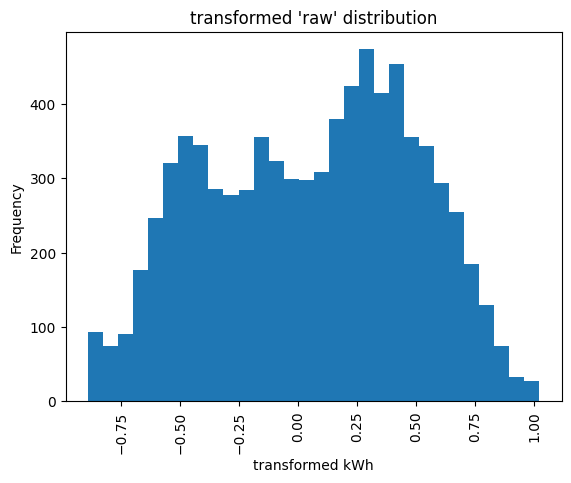

In [73]:
# Transformation

transformed = root_transform(df_notnull['raw'], 1/3)
transformed = root_transform(transformed,1/2)
transformed = log_e_transform(3 - transformed)

transformed.plot.hist(bins=30)

plt.title("transformed 'raw' distribution")
plt.xlabel("transformed kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

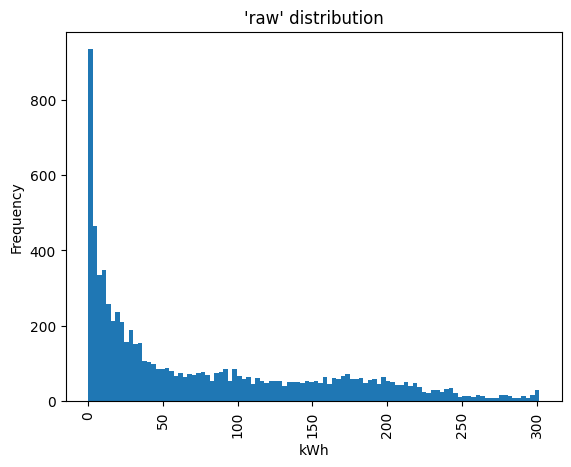

In [74]:
# Back transformation

back_transformed = 3 - log_e_backtransform(transformed)
back_transformed = root_back_transform(back_transformed,2)
back_transformed = root_back_transform(back_transformed, 3)

back_transformed.plot.hist(bins=100)

plt.title("'raw' distribution")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

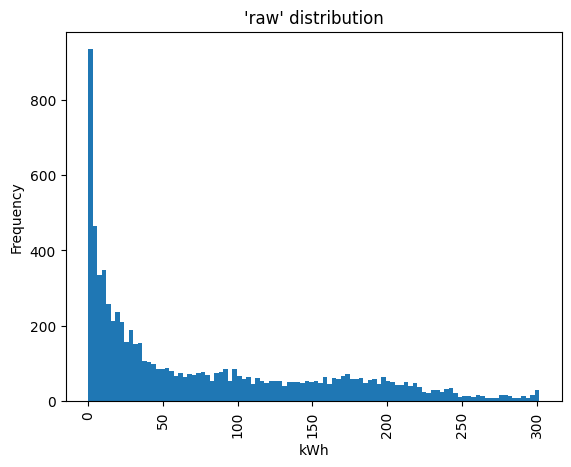

In [75]:
# Origina distribution
df_notnull['raw'].plot.hist(bins=100)

plt.title("'raw' distribution")
plt.xlabel("kWh")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [76]:
# Lets keep needed columns
df = df[['timestamp','datetime','date','step','raw','temperature','hour','month']]
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2

In [77]:
quasi_year_timedelta = pd.to_datetime(df['date']).min() - pd.to_datetime('2021-01-01')

df['quasi_date'] = df['date'] - quasi_year_timedelta
df['quasi_year'] = df['quasi_date'].astype('datetime64[ns]').dt.year

df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  
0  2021-01-01        2021  
1  2021-01-02        2021  
2  2021-01-03        2021

In [78]:
df.groupby('quasi_year')['raw'].sum() - df.groupby('quasi_year')['raw'].sum().min()

quasi_year
2021        0.00000
2022    25586.91089
Name: raw, dtype: float64

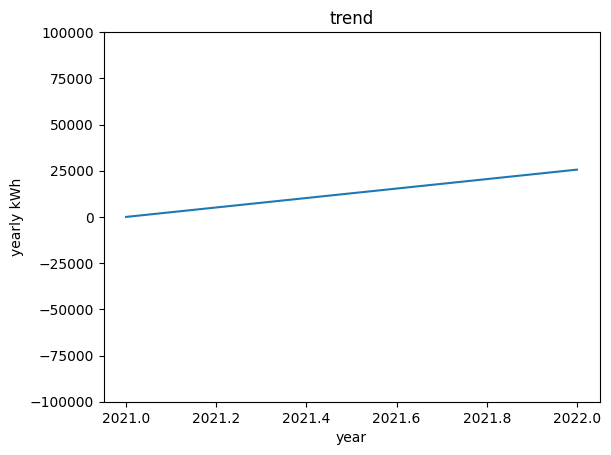

In [79]:
(df.groupby('quasi_year')['raw'].sum() - df.groupby('quasi_year')['raw'].sum().min()).plot()

plt.title("trend")
plt.xlabel("year")
plt.ylabel("yearly kWh")
plt.ylim(-100000,100000)
plt.xticks()
plt.show()

In [80]:
# Now lets create year-month object
df['year'] = df['datetime'].astype('datetime64[ns]').dt.year
df['month'] = df['datetime'].astype('datetime64[ns]').dt.month
df['year_month'] = df['year'].astype('str') + df['month'].astype('str').str.zfill(2)
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  
0  2021-01-01        2021  2021     202102  
1  2021-01-02        2021  2021     202102  
2  2021-01-03        2021  2021     202102

In [81]:
monthly_production = df.groupby(['year','month'])['raw'].sum().reset_index()#.rename(columns={'raw':'mean_monthly_production'})
monthly_production['year_month'] = monthly_production['year'].astype('str') + monthly_production['month'].astype('str').str.zfill(2)
monthly_production.head(3)

year  month          raw year_month
0  2021      2   4227.22569     202102
1  2021      3  25155.05614     202103
2  2021      4  41574.29456     202104

In [82]:
mean_monthly_production = monthly_production.groupby('month')['raw'].mean().reset_index().rename(columns={'raw':'raw_mean'})
mean_monthly_production.head(3)

month      raw_mean
0      1   2314.894200
1      2   4060.010767
2      3  32240.962395

In [83]:
monthly_production = monthly_production.merge(mean_monthly_production,on='month')
monthly_production.head(3)

year  month         raw year_month     raw_mean
0  2021      2  4227.22569     202102  4060.010767
1  2022      2  7863.75500     202202  4060.010767
2  2023      2    89.05161     202302  4060.010767

In [84]:
monthly_production = monthly_production.sort_values(by=['year','month'])
monthly_production.head(3)

year  month          raw year_month      raw_mean
0  2021      2   4227.22569     202102   4060.010767
3  2021      3  25155.05614     202103  32240.962395
5  2021      4  41574.29456     202104  45522.081355

<AxesSubplot: xlabel='year_month'>

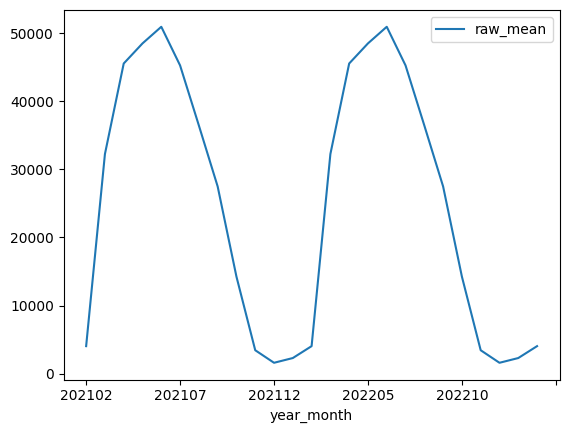

In [85]:
# Plotting seasonality
monthly_production.plot(x='year_month',y='raw_mean')

In [86]:
# Calculating residial
monthly_production['residial'] = monthly_production['raw'] - monthly_production['raw_mean']
monthly_production.head(3)

year  month          raw year_month      raw_mean     residial
0  2021      2   4227.22569     202102   4060.010767   167.214923
3  2021      3  25155.05614     202103  32240.962395 -7085.906255
5  2021      4  41574.29456     202104  45522.081355 -3947.786795

<AxesSubplot: xlabel='year_month'>

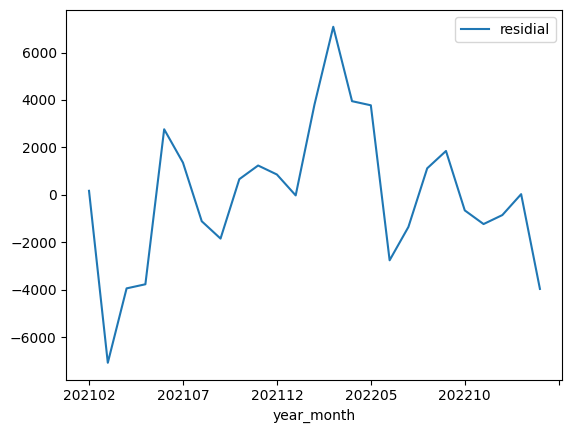

In [87]:
# Plotting residial
monthly_production.plot(x='year_month',y='residial')

<AxesSubplot: >

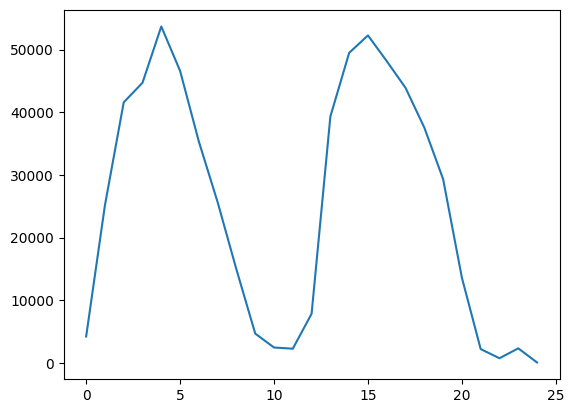

In [88]:
# Plotting original curve using back-engineering
(0 + monthly_production['raw_mean'] + monthly_production['residial']).reset_index(drop=True).plot()

In [89]:
df['day_of_week'] = df['datetime'].dt.dayofweek
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  
0  2021-01-01        2021  2021     202102            1  
1  2021-01-02        2021  2021     202102            2  
2  2021-01-03        2021  2021     202102            3

In [90]:
df['week_number'] = df['datetime'].dt.week
df.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612224000 2021-02-02  2021-02-02     1  0.0         -3.9     0      2   
1  1612310400 2021-02-03  2021-02-03     1  0.0          2.1     0      2   
2  1612396800 2021-02-04  2021-02-04     1  0.0         -0.3     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number  
0  2021-01-01        2021  2021     202102            1            5  
1  2021-01-02        2021  2021     202102            2            5  
2  2021-01-03        2021  2021     202102            3            5

In [91]:
df_count_of_days_in_week_per_year_month = (df.groupby(['year','month','week_number'])['day_of_week'].count() / 24).reset_index()
df_count_of_days_in_week_per_year_month.head(3)

year  month  week_number  day_of_week
0  2021      2            5          6.0
1  2021      2            6          7.0
2  2021      2            7          7.0

In [92]:
# Keep only clean weeks with no inter-month interaction
df_count_of_days_in_week_per_year_month_clean = df_count_of_days_in_week_per_year_month[df_count_of_days_in_week_per_year_month['day_of_week'] == 7].reset_index(drop=True)
df_count_of_days_in_week_per_year_month_clean.head(3)

year  month  week_number  day_of_week
0  2021      2            6          7.0
1  2021      2            7          7.0
2  2021      2            8          7.0

In [93]:
# keep only data which includes whole-month weeks
df_whole_month_week = df.merge(df_count_of_days_in_week_per_year_month_clean[['year','month','week_number']],on=['year','month','week_number'],how='inner').reset_index(drop=True)
df_whole_month_week.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612742400 2021-02-08  2021-02-08     1  0.0         15.2     0      2   
1  1612828800 2021-02-09  2021-02-09     1  0.0          9.7     0      2   
2  1612915200 2021-02-10  2021-02-10     1  0.0          9.0     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number  
0  2021-01-07        2021  2021     202102            0            6  
1  2021-01-08        2021  2021     202102            1            6  
2  2021-01-09        2021  2021     202102            2            6

In [94]:
df_whole_month_week['year_week'] = df_whole_month_week['year'].astype(str) + df_whole_month_week['week_number'].astype(str).str.zfill(2)
df_whole_month_week.head(3)

timestamp   datetime        date  step  raw  temperature  hour  month  \
0  1612742400 2021-02-08  2021-02-08     1  0.0         15.2     0      2   
1  1612828800 2021-02-09  2021-02-09     1  0.0          9.7     0      2   
2  1612915200 2021-02-10  2021-02-10     1  0.0          9.0     0      2   

   quasi_date  quasi_year  year year_month  day_of_week  week_number year_week  
0  2021-01-07        2021  2021     202102            0            6    202106  
1  2021-01-08        2021  2021     202102            1            6    202106  
2  2021-01-09        2021  2021     202102            2            6    202106

In [95]:
df_whole_month_week = df_whole_month_week.sort_values(by=['timestamp']).reset_index(drop=True)
df_whole_month_week.head(3)

timestamp            datetime        date  step  raw  temperature  hour  \
0  1612742400 2021-02-08 00:00:00  2021-02-08     1  0.0         15.2     0   
1  1612746000 2021-02-08 01:00:00  2021-02-08     2  0.0         14.7     1   
2  1612749600 2021-02-08 02:00:00  2021-02-08     3  0.0         14.5     2   

   month  quasi_date  quasi_year  year year_month  day_of_week  week_number  \
0      2  2021-01-07        2021  2021     202102            0            6   
1      2  2021-01-07        2021  2021     202102            0            6   
2      2  2021-01-07        2021  2021     202102            0            6   

  year_week  
0    202106  
1    202106  
2    202106

In [96]:
df_monthly_profile_data = pd.DataFrame(columns=['timestamp','month','year_week','week_number','hour','raw','ts'])

for month in df_whole_month_week['month'].unique():
        
    df_month_profiles = df_whole_month_week[df_whole_month_week['month'] == month].reset_index(drop=True)
    df_month_profiles['ts'] = df_month_profiles.groupby('year_week')['timestamp'].cumcount()
    
    df_month_profiles = df_month_profiles[['timestamp','month','year_week','week_number','hour','raw','ts']]
    
    df_monthly_profile_data = pd.concat([df_monthly_profile_data,df_month_profiles])

df_monthly_profile_data = df_monthly_profile_data.reset_index(drop=True)
df_monthly_profile_data.head(3)

timestamp month year_week week_number hour  raw ts
0  1612742400     2    202106           6    0  0.0  0
1  1612746000     2    202106           6    1  0.0  1
2  1612749600     2    202106           6    2  0.0  2

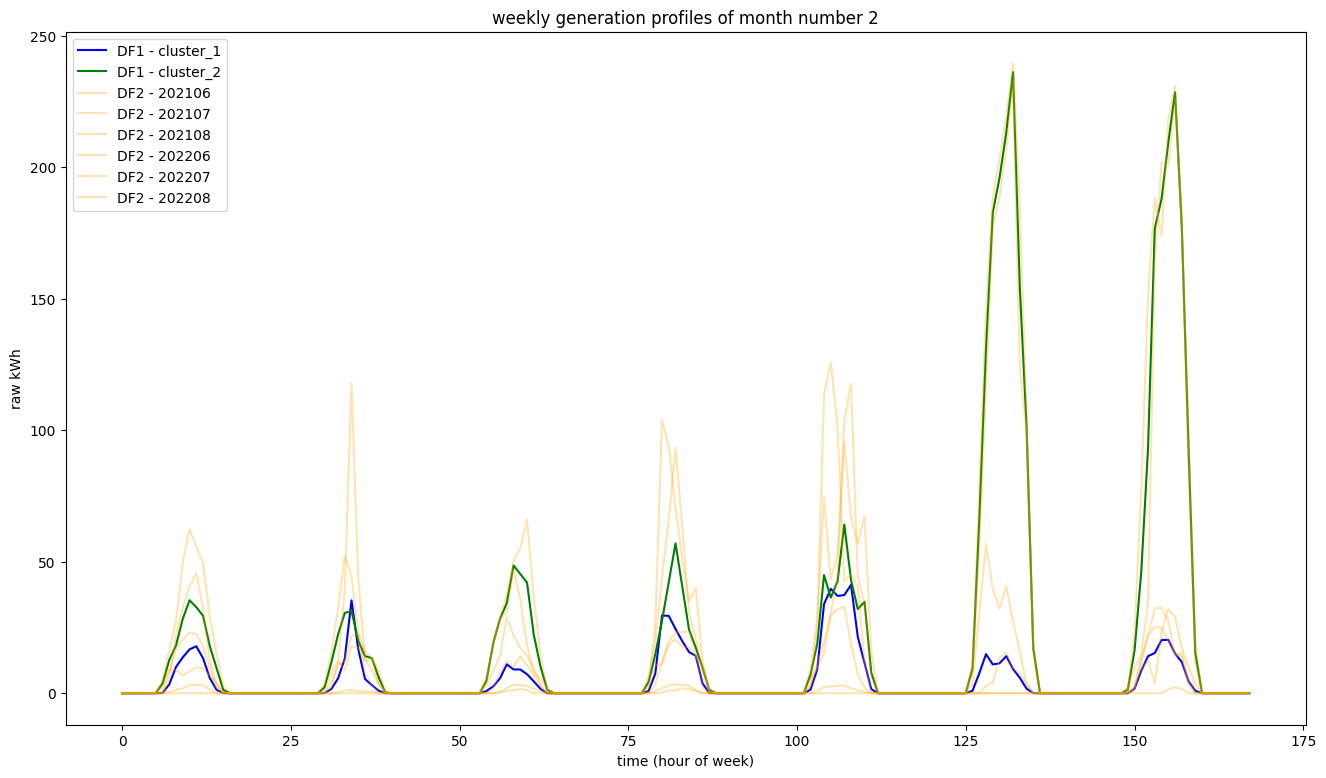

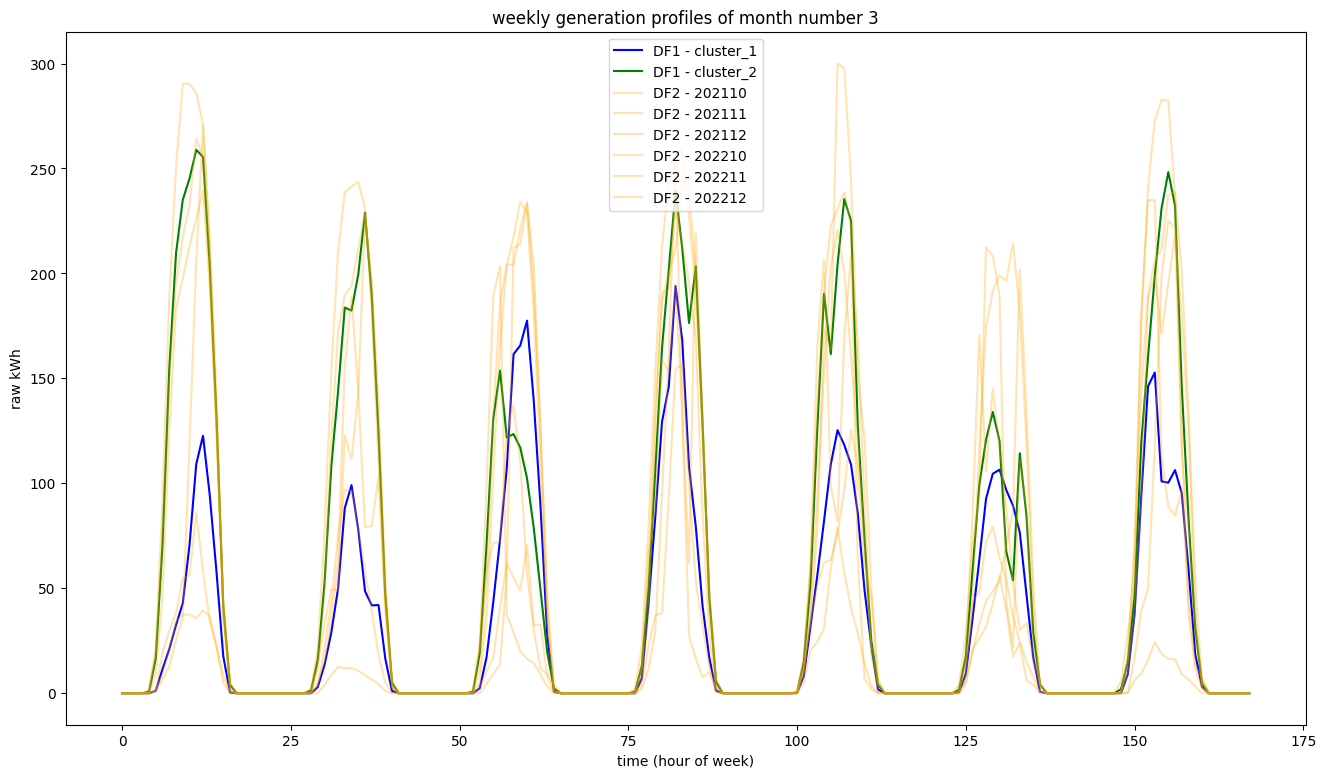

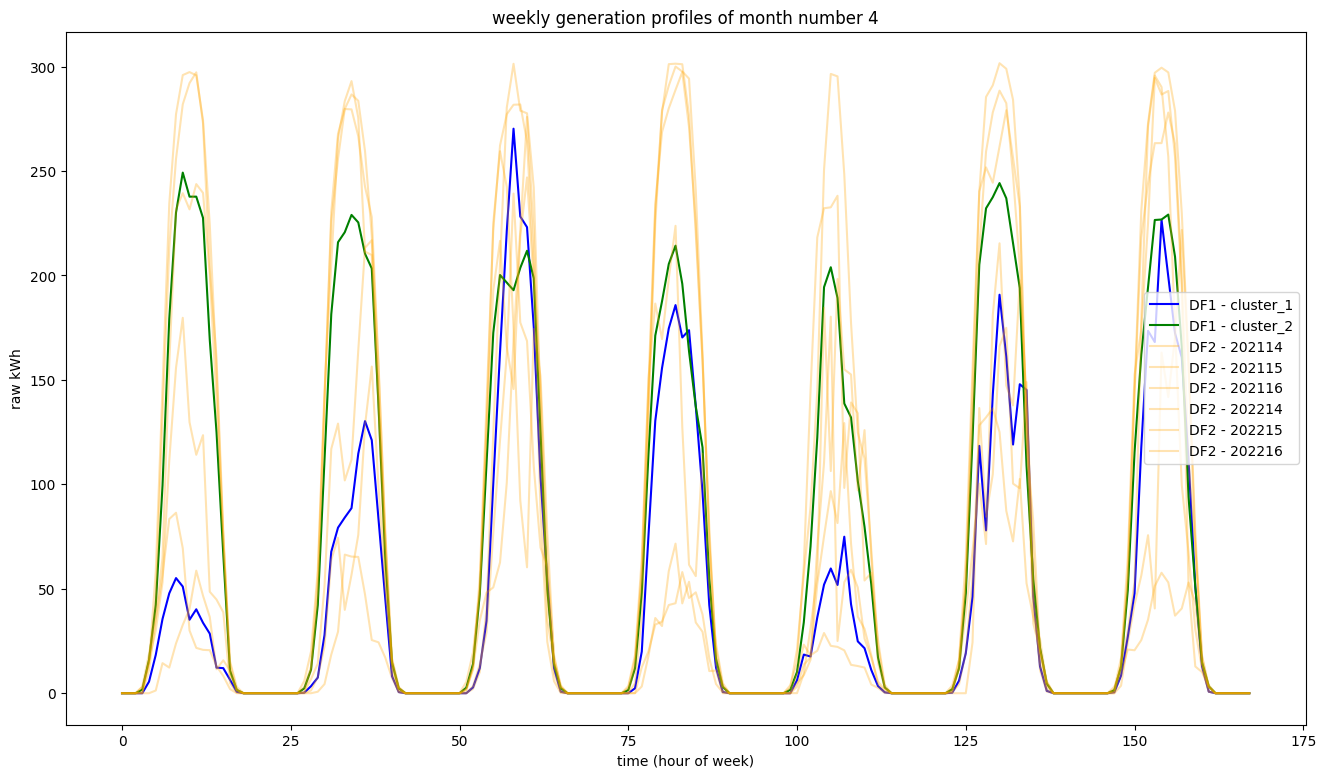

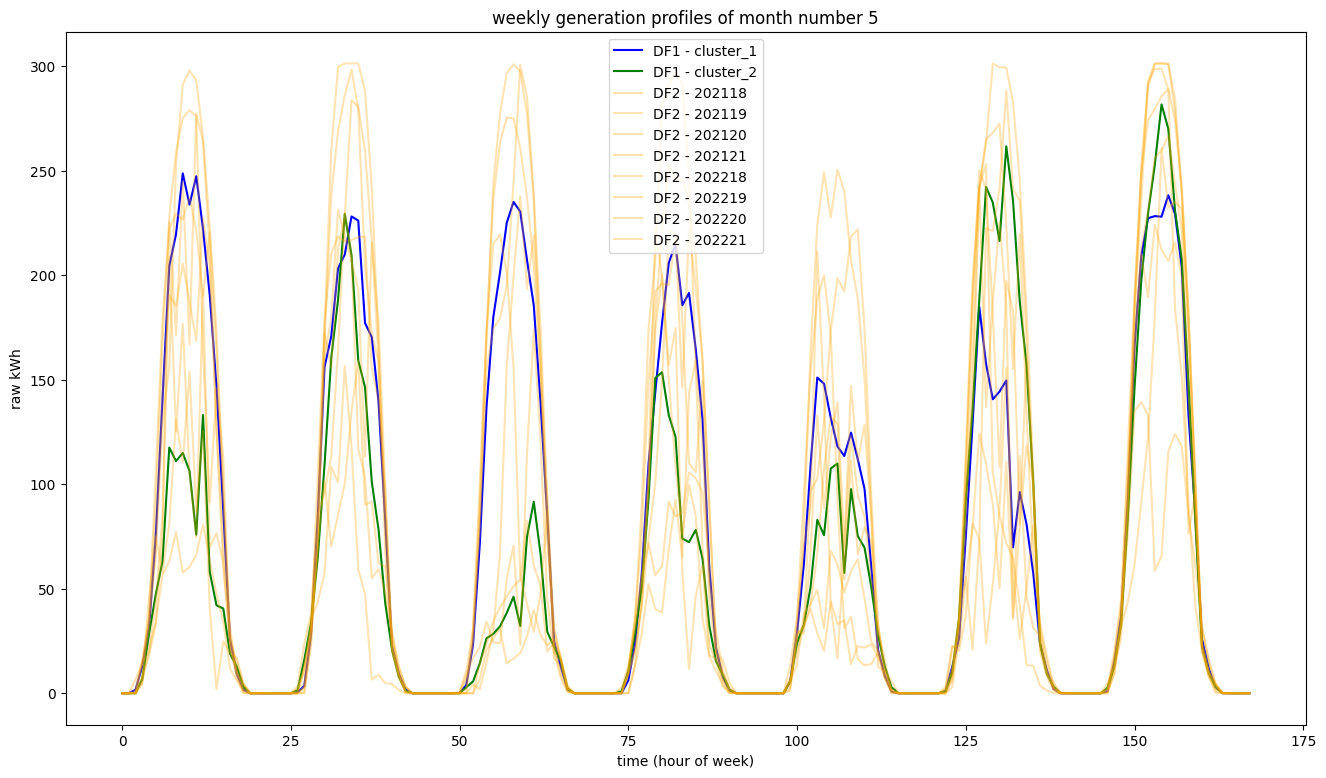

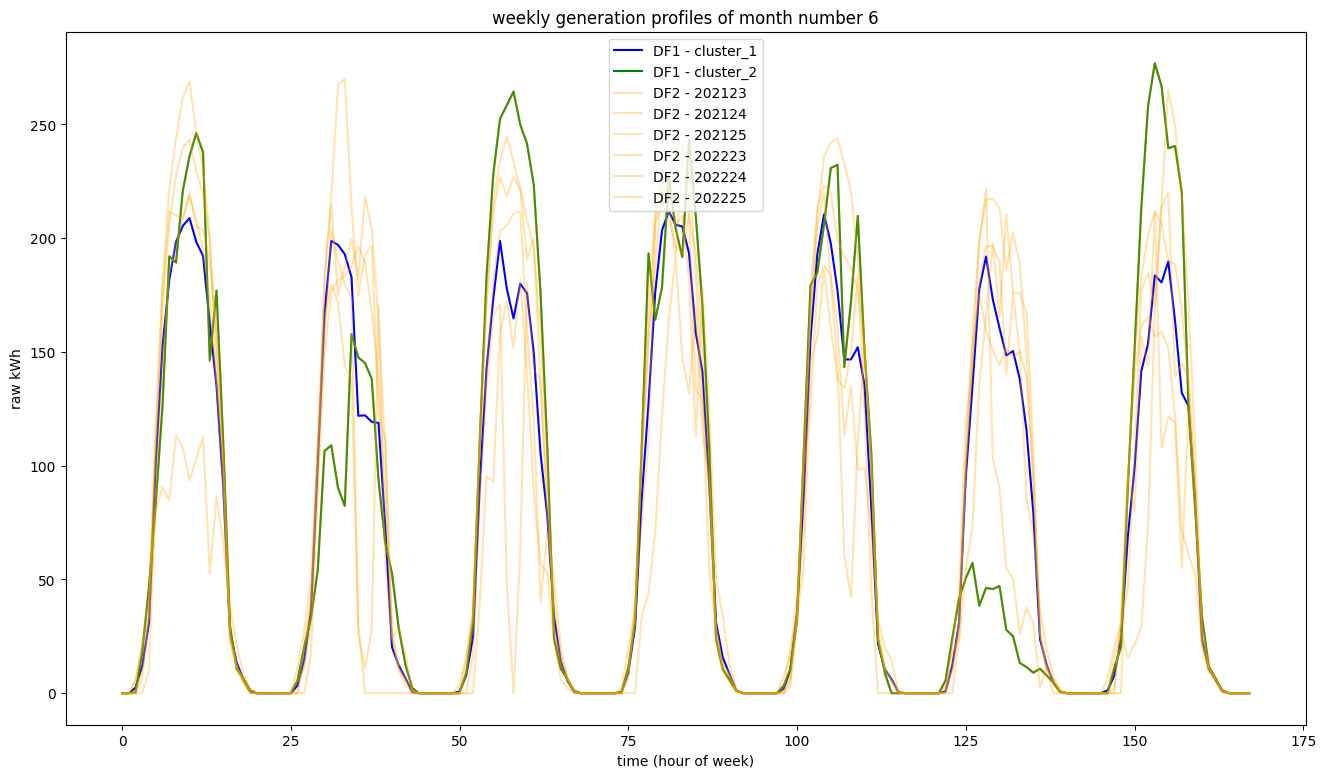

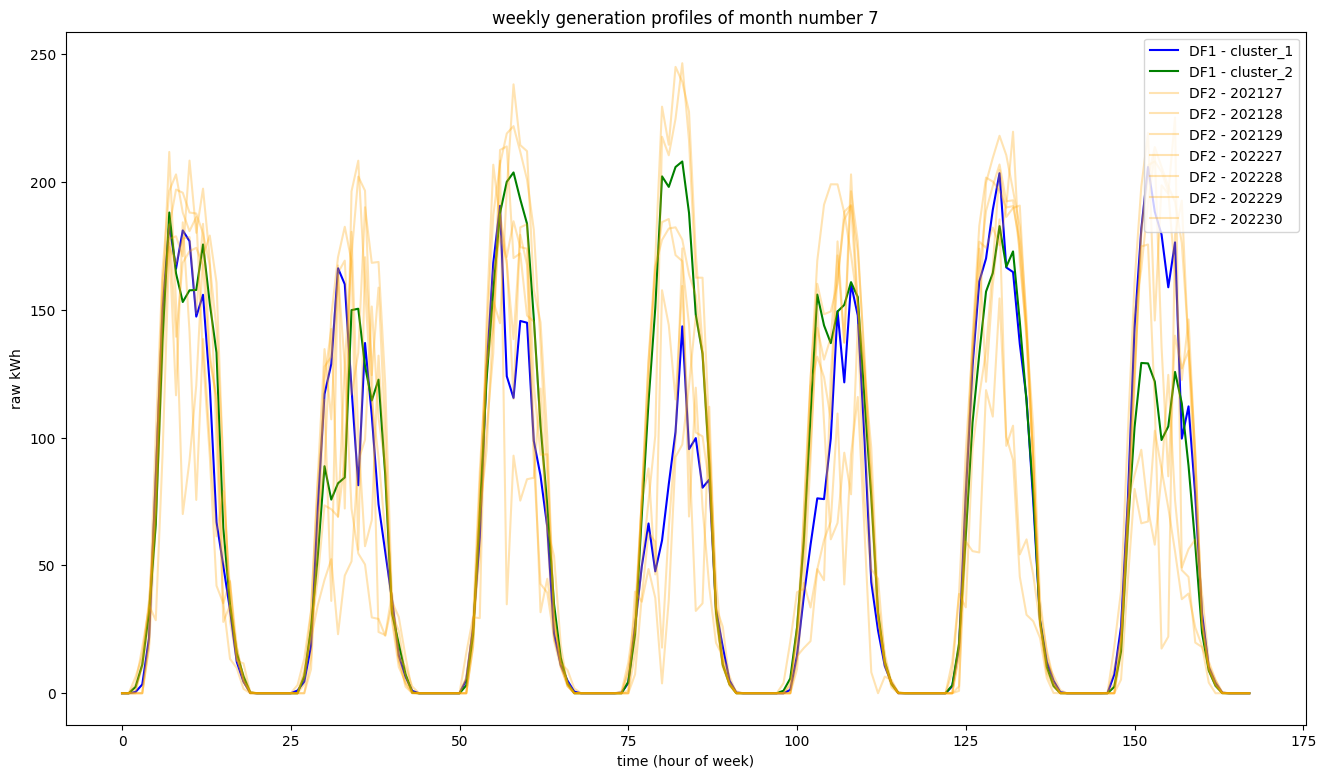

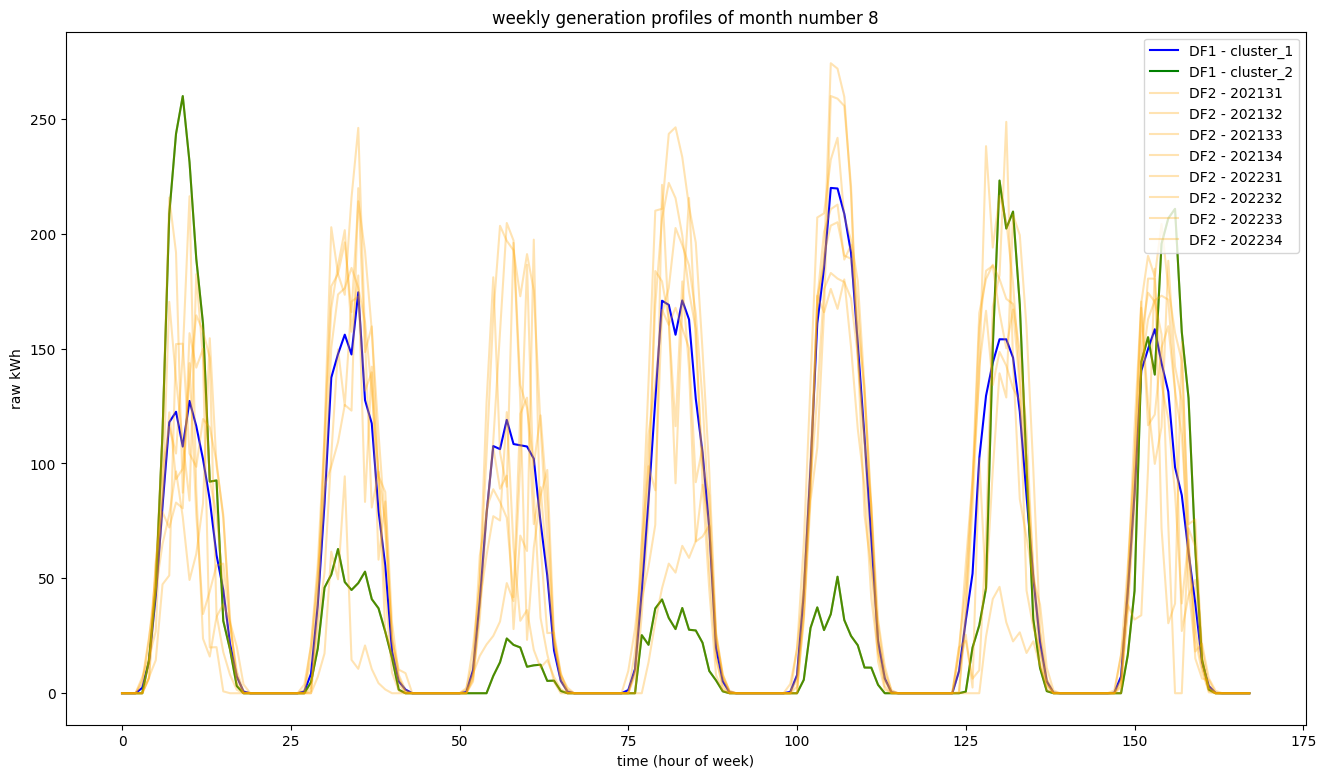

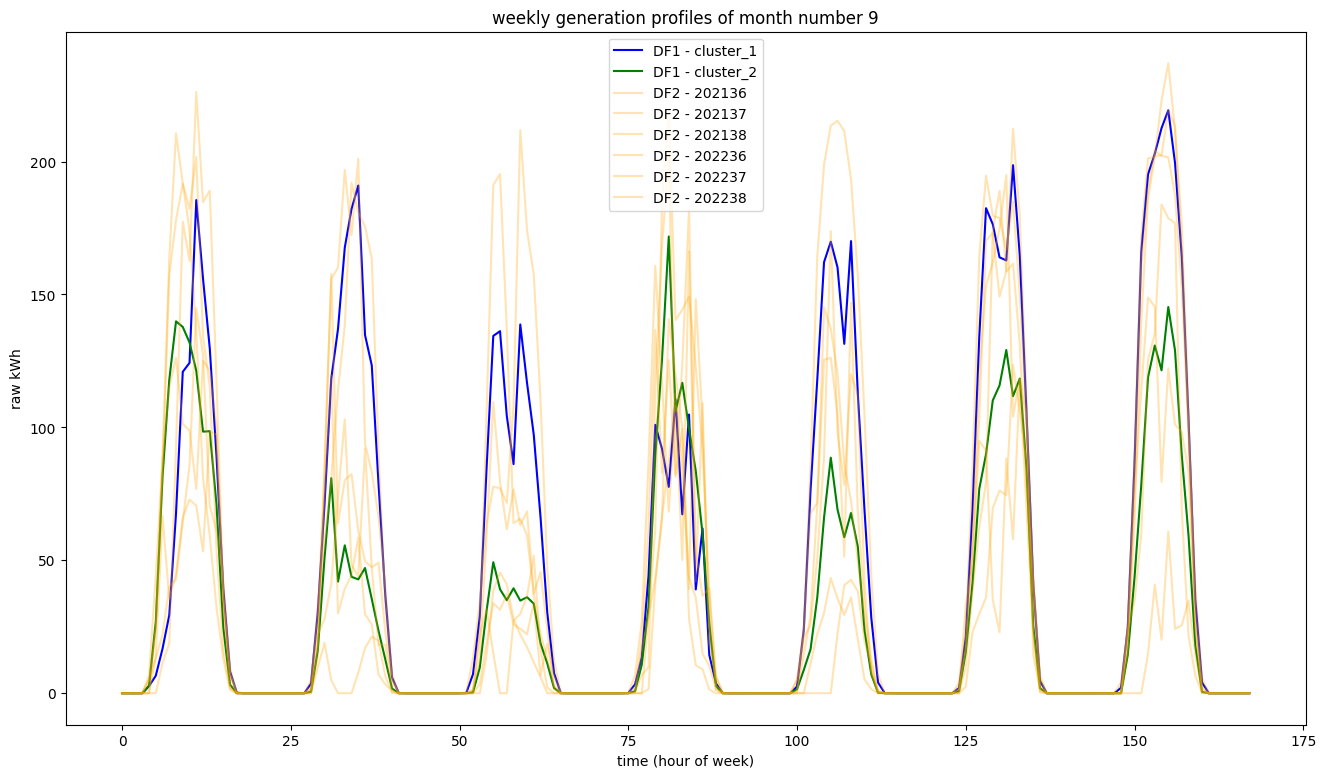

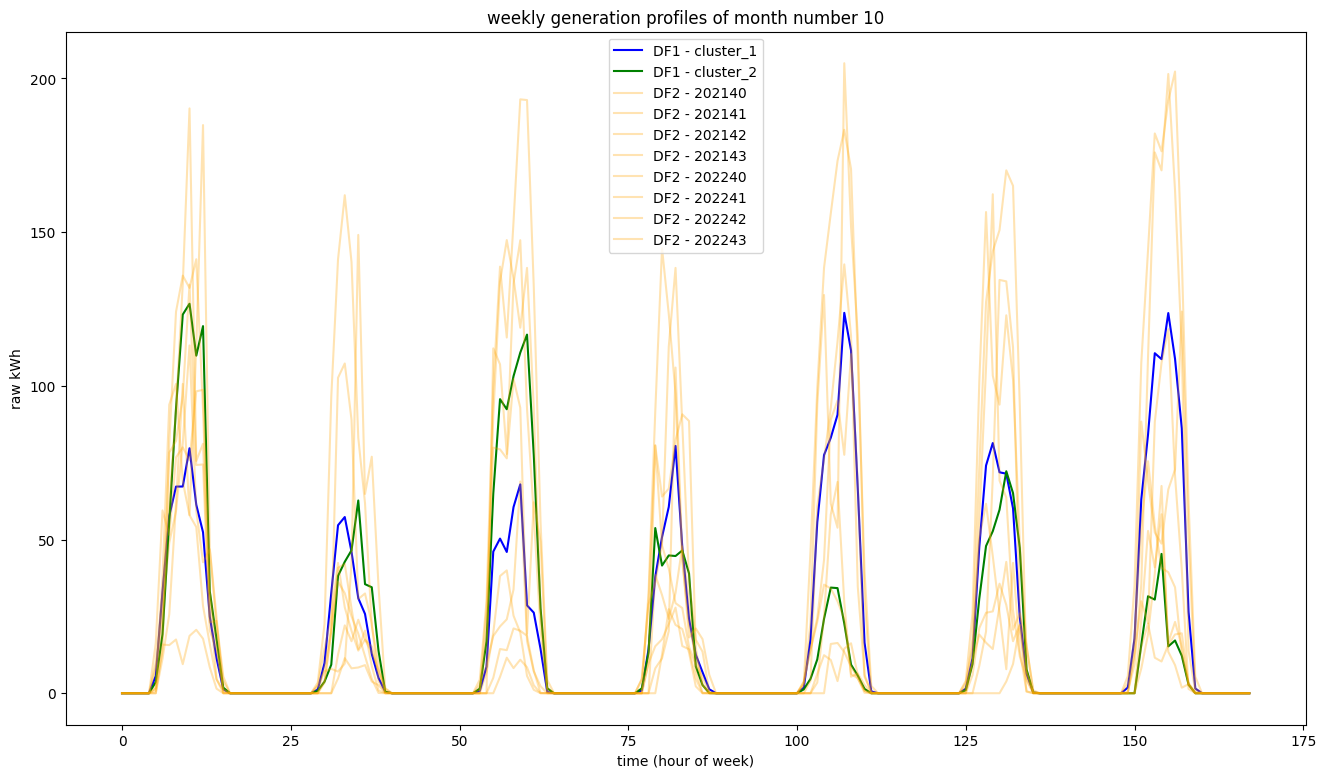

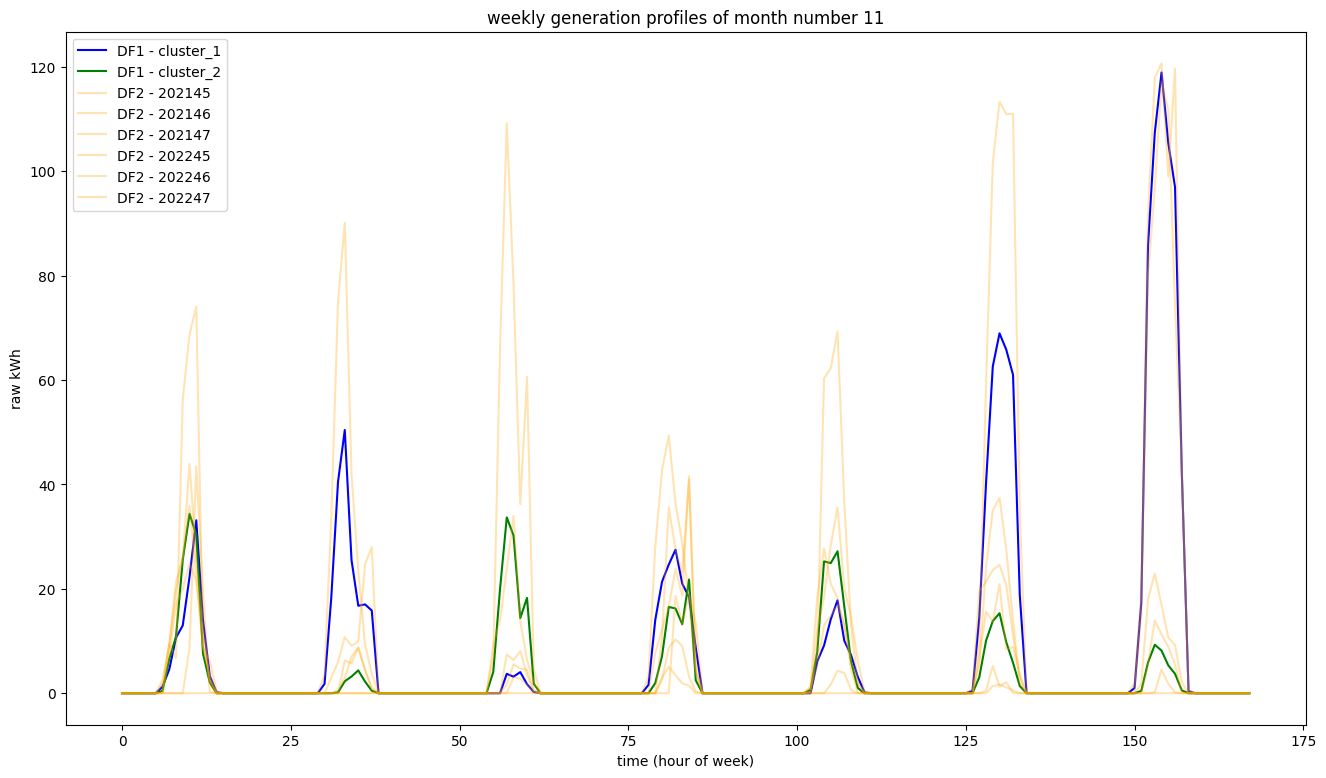

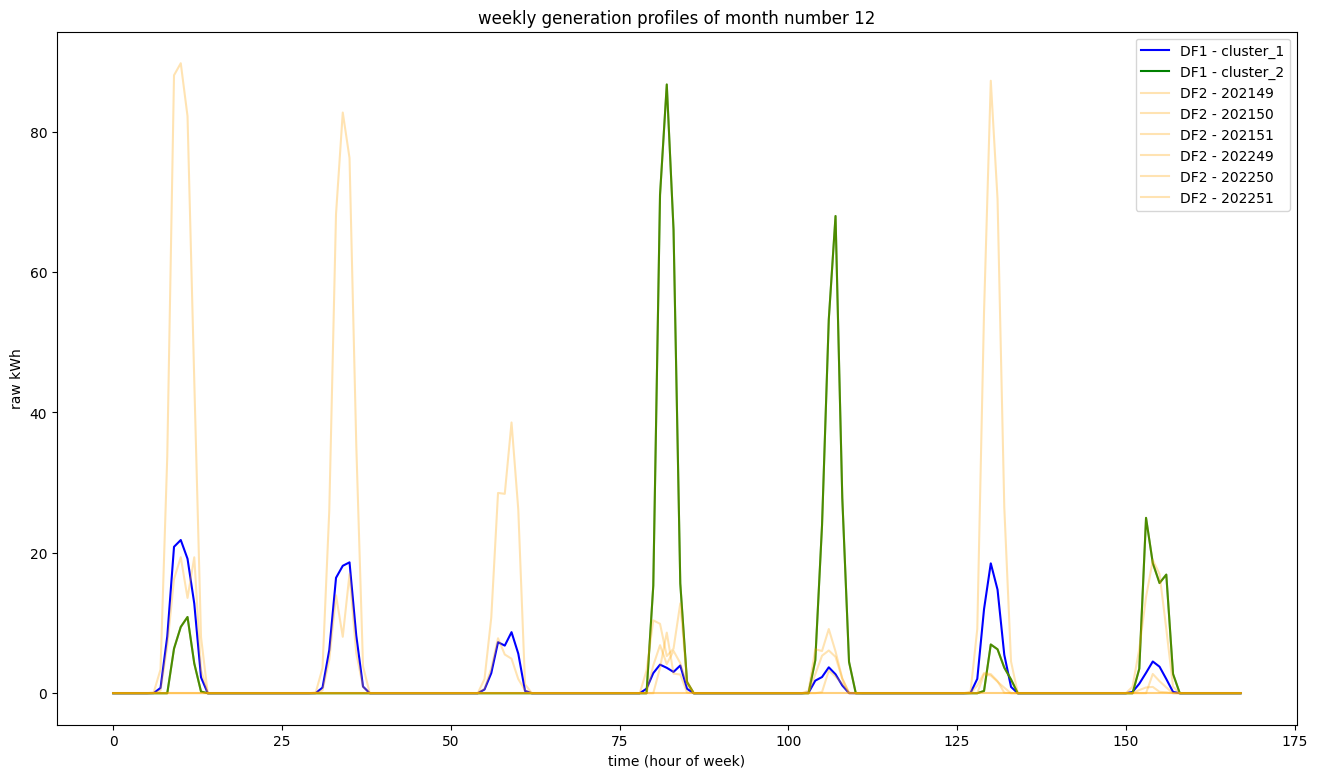

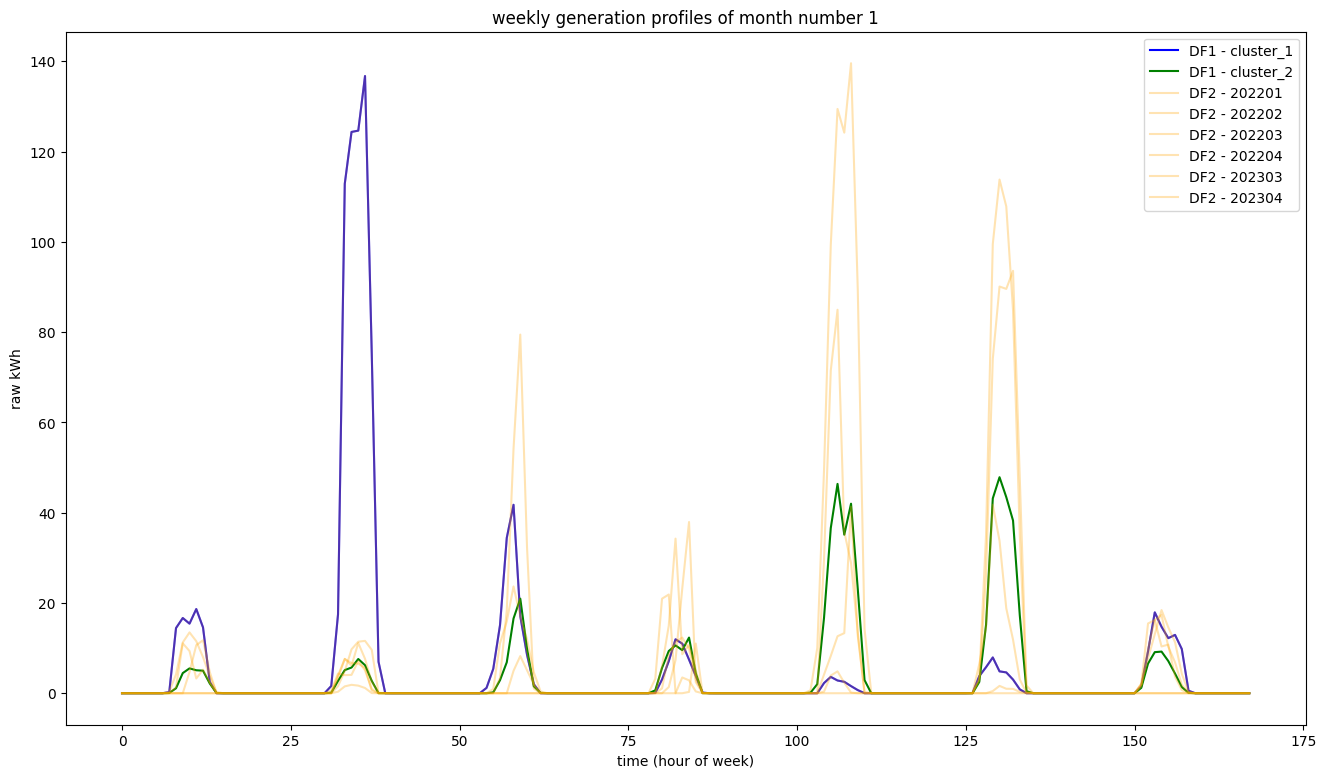

In [97]:
for month in df_monthly_profile_data['month'].unique():
    
    df_helper = df_monthly_profile_data[df_monthly_profile_data['month'] == month]
        
    weekly_data = df_helper.pivot(index='year_week', columns='ts', values='raw')
    weekly_data.columns = [f'hour_{i}' for i in range(168)]
    
    kmeans = KMeans(n_clusters=2, random_state=0)
    kmeans.fit_predict(weekly_data)
    
    min_max_weekly_profiles = kmeans.cluster_centers_
        
    df_clusters = pd.DataFrame(columns=['year_week','ts','raw'])
    
    df_cluster_1 = pd.DataFrame(min_max_weekly_profiles[0],columns=['raw'])
    df_cluster_1['ts'] = df_cluster_1.index
    df_cluster_1['year_week'] = 'cluster_1'
    
    df_cluster_2 = pd.DataFrame(min_max_weekly_profiles[1],columns=['raw'])
    df_cluster_2['ts'] = df_cluster_2.index
    df_cluster_2['year_week'] = 'cluster_2'
    
    df_clusters = pd.concat([df_cluster_1,df_cluster_2],axis=0).reset_index(drop=True)    
            
    plt.figure(figsize=(16, 9))
    
    colors = itertools.cycle(['blue', 'green', 'purple', 'red', 'cyan', 'magenta'])

    for cluster_name, group in df_clusters.groupby('year_week'):
        plt.plot(group['ts'], group['raw'], label=f'DF1 - {cluster_name}', color=next(colors), alpha=1)

    for year_week, group in df_helper.groupby('year_week'):
        plt.plot(group['ts'], group['raw'], label=f'DF2 - {year_week}', color='orange', alpha=0.3)

    plt.xlabel('time (hour of week)')
    plt.ylabel('raw kWh')
    plt.title('weekly generation profiles of month number ' + str(month))
    plt.legend()
    plt.show()
